# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in
TensorFlow.  For example, suppose we are building a biological reinforcement learning
model, but we'd like the inputs to our model to be natural images rather than artificial
vectors.  We could load a vision network from TensorFlow, insert it into our model using
NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the
[TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to
write code directly in TensorFlow, and then insert it easily into Nengo.  In this
example we will demonstrate how to integrate a Keras network into a Nengo model in a
series of stages. First, inserting an entire Keras model, second, inserting individual
Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the
node to insert Python code into our model we will use it to insert TensorFlow code.

The first thing we need to do is define our TensorNode output.  This is a function that
accepts the current simulation time (and, optionally, a batch of vectors) as input, and
produces a batch of vectors as output.  All of these variables will be represented as
`tf.Tensor` objects, and the internal operations of the TensorNode will be implemented
with TensorFlow operations. For example, we could use a TensorNode to output a `sin`
function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

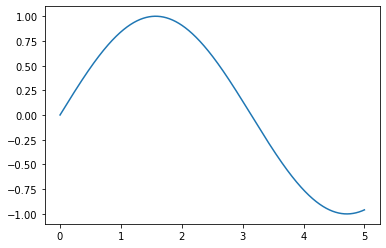

In [2]:
with nengo.Network() as net:

    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)

        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))

        return output

    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)

plt.figure()
plt.plot(sim.trange(), sim.data[p])
plt.show()

However, outputting a `sin` function is something we could do more easily with a regular
`nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more
complex TensorFlow code and insert it into a NengoDL model. For example, one thing we
often want to do is take a deep network written in TensorFlow/Keras, and add it into a
Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software
package for building and training deep learning style networks.  It is a higher-level
API within TensorFlow to make it easier to construct and train deep networks.  And
because it is all implemented as a TensorFlow network under the hood, we can define a
network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the
[introduction in the Tensorflow
documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are
not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.
This dataset contains images of clothing, and the goal of the network is to identify
what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

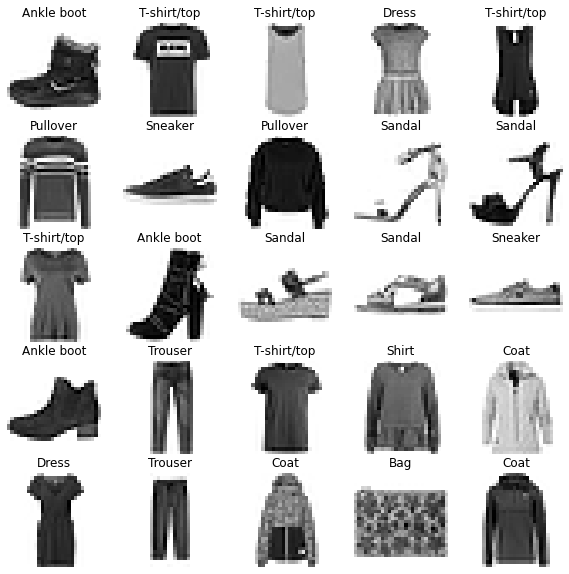

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're
building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in
NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do
everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 20:31 - loss: 2.2751 - accuracy: 0.0938

  29/1875 [..............................] - ETA: 3s - loss: 1.3424 - accuracy: 0.5334   

  56/1875 [..............................] - ETA: 3s - loss: 1.1263 - accuracy: 0.6066

  85/1875 [>.............................] - ETA: 3s - loss: 0.9781 - accuracy: 0.6566

 113/1875 [>.............................] - ETA: 3s - loss: 0.8927 - accuracy: 0.6867

 142/1875 [=>............................] - ETA: 3s - loss: 0.8407 - accuracy: 0.7038

 171/1875 [=>............................] - ETA: 3s - loss: 0.7996 - accuracy: 0.7186

 199/1875 [==>...........................] - ETA: 3s - loss: 0.7809 - accuracy: 0.7242

 228/1875 [==>...........................] - ETA: 2s - loss: 0.7504 - accuracy: 0.7377

 256/1875 [===>..........................] - ETA: 2s - loss: 0.7295 - accuracy: 0.7448

 285/1875 [===>..........................] - ETA: 2s - loss: 0.7095 - accuracy: 0.7516

 315/1875 [====>.........................] - ETA: 2s - loss: 0.6951 - accuracy: 0.7555

 342/1875 [====>.........................] - ETA: 2s - loss: 0.6839 - accuracy: 0.7596

 369/1875 [====>.........................] - ETA: 2s - loss: 0.6756 - accuracy: 0.7622

 399/1875 [=====>........................] - ETA: 2s - loss: 0.6670 - accuracy: 0.7664

 428/1875 [=====>........................] - ETA: 2s - loss: 0.6569 - accuracy: 0.7698

 449/1875 [======>.......................] - ETA: 2s - loss: 0.6486 - accuracy: 0.7726

 474/1875 [======>.......................] - ETA: 2s - loss: 0.6416 - accuracy: 0.7755

 504/1875 [=======>......................] - ETA: 2s - loss: 0.6362 - accuracy: 0.7768

 532/1875 [=======>......................] - ETA: 2s - loss: 0.6283 - accuracy: 0.7795

 560/1875 [=======>......................] - ETA: 2s - loss: 0.6219 - accuracy: 0.7823

 586/1875 [========>.....................] - ETA: 2s - loss: 0.6189 - accuracy: 0.7830

 610/1875 [========>.....................] - ETA: 2s - loss: 0.6135 - accuracy: 0.7845

 637/1875 [=========>....................] - ETA: 2s - loss: 0.6103 - accuracy: 0.7863

 663/1875 [=========>....................] - ETA: 2s - loss: 0.6047 - accuracy: 0.7887

 683/1875 [=========>....................] - ETA: 2s - loss: 0.5998 - accuracy: 0.7905

 702/1875 [==========>...................] - ETA: 2s - loss: 0.5959 - accuracy: 0.7919

 724/1875 [==========>...................] - ETA: 2s - loss: 0.5933 - accuracy: 0.7926

 750/1875 [===========>..................] - ETA: 2s - loss: 0.5873 - accuracy: 0.7945

 777/1875 [===========>..................] - ETA: 2s - loss: 0.5852 - accuracy: 0.7943

 805/1875 [===========>..................] - ETA: 2s - loss: 0.5806 - accuracy: 0.7958

 833/1875 [============>.................] - ETA: 1s - loss: 0.5785 - accuracy: 0.7962

 859/1875 [============>.................] - ETA: 1s - loss: 0.5761 - accuracy: 0.7970

 885/1875 [=============>................] - ETA: 1s - loss: 0.5734 - accuracy: 0.7983

 910/1875 [=============>................] - ETA: 1s - loss: 0.5692 - accuracy: 0.8000

 939/1875 [==============>...............] - ETA: 1s - loss: 0.5641 - accuracy: 0.8021

 966/1875 [==============>...............] - ETA: 1s - loss: 0.5617 - accuracy: 0.8029

 991/1875 [==============>...............] - ETA: 1s - loss: 0.5588 - accuracy: 0.8039

1018/1875 [===============>..............] - ETA: 1s - loss: 0.5551 - accuracy: 0.8053

1047/1875 [===============>..............] - ETA: 1s - loss: 0.5525 - accuracy: 0.8062

1076/1875 [================>.............] - ETA: 1s - loss: 0.5493 - accuracy: 0.8072

1103/1875 [================>.............] - ETA: 1s - loss: 0.5471 - accuracy: 0.8080

1132/1875 [=================>............] - ETA: 1s - loss: 0.5442 - accuracy: 0.8092

1158/1875 [=================>............] - ETA: 1s - loss: 0.5422 - accuracy: 0.8097

1184/1875 [=================>............] - ETA: 1s - loss: 0.5391 - accuracy: 0.8106

1209/1875 [==================>...........] - ETA: 1s - loss: 0.5368 - accuracy: 0.8114

1238/1875 [==================>...........] - ETA: 1s - loss: 0.5346 - accuracy: 0.8121

1267/1875 [===================>..........] - ETA: 1s - loss: 0.5328 - accuracy: 0.8130

1297/1875 [===================>..........] - ETA: 1s - loss: 0.5311 - accuracy: 0.8137

1326/1875 [====================>.........] - ETA: 1s - loss: 0.5292 - accuracy: 0.8145

1355/1875 [====================>.........] - ETA: 0s - loss: 0.5270 - accuracy: 0.8153

1384/1875 [=====================>........] - ETA: 0s - loss: 0.5249 - accuracy: 0.8160

1414/1875 [=====================>........] - ETA: 0s - loss: 0.5223 - accuracy: 0.8168

1442/1875 [======================>.......] - ETA: 0s - loss: 0.5205 - accuracy: 0.8173

1471/1875 [======================>.......] - ETA: 0s - loss: 0.5185 - accuracy: 0.8181

1499/1875 [======================>.......] - ETA: 0s - loss: 0.5160 - accuracy: 0.8190

1528/1875 [=======================>......] - ETA: 0s - loss: 0.5149 - accuracy: 0.8194

1558/1875 [=======================>......] - ETA: 0s - loss: 0.5138 - accuracy: 0.8197

1586/1875 [========================>.....] - ETA: 0s - loss: 0.5129 - accuracy: 0.8199

1614/1875 [========================>.....] - ETA: 0s - loss: 0.5116 - accuracy: 0.8204

1643/1875 [=========================>....] - ETA: 0s - loss: 0.5095 - accuracy: 0.8210

1670/1875 [=========================>....] - ETA: 0s - loss: 0.5076 - accuracy: 0.8218

1697/1875 [==========================>...] - ETA: 0s - loss: 0.5070 - accuracy: 0.8220

1725/1875 [==========================>...] - ETA: 0s - loss: 0.5061 - accuracy: 0.8223

1753/1875 [===========================>..] - ETA: 0s - loss: 0.5034 - accuracy: 0.8232

1780/1875 [===========================>..] - ETA: 0s - loss: 0.5018 - accuracy: 0.8238

1807/1875 [===========================>..] - ETA: 0s - loss: 0.5012 - accuracy: 0.8239

1831/1875 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8245

1854/1875 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8245

1875/1875 [==============================] - 4s 2ms/step - loss: 0.4992 - accuracy: 0.8246


Epoch 2/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1635 - accuracy: 0.9688

  30/1875 [..............................] - ETA: 3s - loss: 0.3732 - accuracy: 0.8729

  58/1875 [..............................] - ETA: 3s - loss: 0.3631 - accuracy: 0.8798

  87/1875 [>.............................] - ETA: 3s - loss: 0.3849 - accuracy: 0.8671

 117/1875 [>.............................] - ETA: 3s - loss: 0.3891 - accuracy: 0.8659

 145/1875 [=>............................] - ETA: 3s - loss: 0.3933 - accuracy: 0.8603

 174/1875 [=>............................] - ETA: 3s - loss: 0.3983 - accuracy: 0.8576

 202/1875 [==>...........................] - ETA: 2s - loss: 0.3918 - accuracy: 0.8605

 232/1875 [==>...........................] - ETA: 2s - loss: 0.3893 - accuracy: 0.8611

 262/1875 [===>..........................] - ETA: 2s - loss: 0.3893 - accuracy: 0.8608

 289/1875 [===>..........................] - ETA: 2s - loss: 0.3987 - accuracy: 0.8572

 318/1875 [====>.........................] - ETA: 2s - loss: 0.3981 - accuracy: 0.8577

 346/1875 [====>.........................] - ETA: 2s - loss: 0.3937 - accuracy: 0.8589

 372/1875 [====>.........................] - ETA: 2s - loss: 0.3906 - accuracy: 0.8592

 400/1875 [=====>........................] - ETA: 2s - loss: 0.3879 - accuracy: 0.8589

 429/1875 [=====>........................] - ETA: 2s - loss: 0.3889 - accuracy: 0.8588

 459/1875 [======>.......................] - ETA: 2s - loss: 0.3871 - accuracy: 0.8594

 486/1875 [======>.......................] - ETA: 2s - loss: 0.3852 - accuracy: 0.8601

 514/1875 [=======>......................] - ETA: 2s - loss: 0.3875 - accuracy: 0.8594

 544/1875 [=======>......................] - ETA: 2s - loss: 0.3844 - accuracy: 0.8607

 571/1875 [========>.....................] - ETA: 2s - loss: 0.3854 - accuracy: 0.8600

 601/1875 [========>.....................] - ETA: 2s - loss: 0.3857 - accuracy: 0.8596

 630/1875 [=========>....................] - ETA: 2s - loss: 0.3851 - accuracy: 0.8599

 660/1875 [=========>....................] - ETA: 2s - loss: 0.3868 - accuracy: 0.8589

 689/1875 [==========>...................] - ETA: 2s - loss: 0.3854 - accuracy: 0.8593

 718/1875 [==========>...................] - ETA: 2s - loss: 0.3867 - accuracy: 0.8585

 746/1875 [==========>...................] - ETA: 2s - loss: 0.3867 - accuracy: 0.8588

 774/1875 [===========>..................] - ETA: 1s - loss: 0.3862 - accuracy: 0.8594

 803/1875 [===========>..................] - ETA: 1s - loss: 0.3867 - accuracy: 0.8589

 831/1875 [============>.................] - ETA: 1s - loss: 0.3859 - accuracy: 0.8591

 859/1875 [============>.................] - ETA: 1s - loss: 0.3841 - accuracy: 0.8606

 888/1875 [=============>................] - ETA: 1s - loss: 0.3840 - accuracy: 0.8609

 914/1875 [=============>................] - ETA: 1s - loss: 0.3832 - accuracy: 0.8615

 939/1875 [==============>...............] - ETA: 1s - loss: 0.3825 - accuracy: 0.8615

 968/1875 [==============>...............] - ETA: 1s - loss: 0.3822 - accuracy: 0.8612

 997/1875 [==============>...............] - ETA: 1s - loss: 0.3818 - accuracy: 0.8612

1027/1875 [===============>..............] - ETA: 1s - loss: 0.3816 - accuracy: 0.8611

1055/1875 [===============>..............] - ETA: 1s - loss: 0.3814 - accuracy: 0.8613

1083/1875 [================>.............] - ETA: 1s - loss: 0.3800 - accuracy: 0.8618

1112/1875 [================>.............] - ETA: 1s - loss: 0.3789 - accuracy: 0.8624

1141/1875 [=================>............] - ETA: 1s - loss: 0.3778 - accuracy: 0.8628

1169/1875 [=================>............] - ETA: 1s - loss: 0.3783 - accuracy: 0.8626

1198/1875 [==================>...........] - ETA: 1s - loss: 0.3782 - accuracy: 0.8629

1227/1875 [==================>...........] - ETA: 1s - loss: 0.3790 - accuracy: 0.8626

1255/1875 [===================>..........] - ETA: 1s - loss: 0.3788 - accuracy: 0.8628

1283/1875 [===================>..........] - ETA: 1s - loss: 0.3792 - accuracy: 0.8624

1311/1875 [===================>..........] - ETA: 1s - loss: 0.3803 - accuracy: 0.8619

1340/1875 [====================>.........] - ETA: 0s - loss: 0.3811 - accuracy: 0.8617

1369/1875 [====================>.........] - ETA: 0s - loss: 0.3802 - accuracy: 0.8621

1397/1875 [=====================>........] - ETA: 0s - loss: 0.3798 - accuracy: 0.8622

1426/1875 [=====================>........] - ETA: 0s - loss: 0.3787 - accuracy: 0.8626

1454/1875 [======================>.......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8625

1483/1875 [======================>.......] - ETA: 0s - loss: 0.3791 - accuracy: 0.8628

1509/1875 [=======================>......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8626

1538/1875 [=======================>......] - ETA: 0s - loss: 0.3793 - accuracy: 0.8627

1568/1875 [========================>.....] - ETA: 0s - loss: 0.3797 - accuracy: 0.8628

1592/1875 [========================>.....] - ETA: 0s - loss: 0.3799 - accuracy: 0.8628

1615/1875 [========================>.....] - ETA: 0s - loss: 0.3793 - accuracy: 0.8629

1644/1875 [=========================>....] - ETA: 0s - loss: 0.3784 - accuracy: 0.8631

1671/1875 [=========================>....] - ETA: 0s - loss: 0.3780 - accuracy: 0.8634

1698/1875 [==========================>...] - ETA: 0s - loss: 0.3784 - accuracy: 0.8633

1728/1875 [==========================>...] - ETA: 0s - loss: 0.3780 - accuracy: 0.8633

1757/1875 [===========================>..] - ETA: 0s - loss: 0.3779 - accuracy: 0.8634

1786/1875 [===========================>..] - ETA: 0s - loss: 0.3772 - accuracy: 0.8637

1815/1875 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8636

1845/1875 [============================>.] - ETA: 0s - loss: 0.3760 - accuracy: 0.8642

1875/1875 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8644

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3758 - accuracy: 0.8644


Epoch 3/5


   1/1875 [..............................] - ETA: 4s - loss: 0.4776 - accuracy: 0.8438

  29/1875 [..............................] - ETA: 3s - loss: 0.3327 - accuracy: 0.8696

  50/1875 [..............................] - ETA: 3s - loss: 0.3629 - accuracy: 0.8644

  79/1875 [>.............................] - ETA: 3s - loss: 0.3639 - accuracy: 0.8631

 106/1875 [>.............................] - ETA: 3s - loss: 0.3500 - accuracy: 0.8673

 136/1875 [=>............................] - ETA: 3s - loss: 0.3448 - accuracy: 0.8702

 166/1875 [=>............................] - ETA: 3s - loss: 0.3440 - accuracy: 0.8709

 195/1875 [==>...........................] - ETA: 3s - loss: 0.3377 - accuracy: 0.8744

 224/1875 [==>...........................] - ETA: 3s - loss: 0.3322 - accuracy: 0.8775

 253/1875 [===>..........................] - ETA: 2s - loss: 0.3341 - accuracy: 0.8755

 280/1875 [===>..........................] - ETA: 2s - loss: 0.3338 - accuracy: 0.8758

 307/1875 [===>..........................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8753

 337/1875 [====>.........................] - ETA: 2s - loss: 0.3346 - accuracy: 0.8760

 367/1875 [====>.........................] - ETA: 2s - loss: 0.3333 - accuracy: 0.8766

 392/1875 [=====>........................] - ETA: 2s - loss: 0.3321 - accuracy: 0.8768

 416/1875 [=====>........................] - ETA: 2s - loss: 0.3347 - accuracy: 0.8757

 437/1875 [=====>........................] - ETA: 2s - loss: 0.3325 - accuracy: 0.8760

 464/1875 [======>.......................] - ETA: 2s - loss: 0.3358 - accuracy: 0.8759

 490/1875 [======>.......................] - ETA: 2s - loss: 0.3355 - accuracy: 0.8757

 519/1875 [=======>......................] - ETA: 2s - loss: 0.3386 - accuracy: 0.8749

 549/1875 [=======>......................] - ETA: 2s - loss: 0.3388 - accuracy: 0.8750

 579/1875 [========>.....................] - ETA: 2s - loss: 0.3362 - accuracy: 0.8767

 608/1875 [========>.....................] - ETA: 2s - loss: 0.3369 - accuracy: 0.8759

 638/1875 [=========>....................] - ETA: 2s - loss: 0.3383 - accuracy: 0.8757

 668/1875 [=========>....................] - ETA: 2s - loss: 0.3383 - accuracy: 0.8757

 697/1875 [==========>...................] - ETA: 2s - loss: 0.3391 - accuracy: 0.8751

 727/1875 [==========>...................] - ETA: 2s - loss: 0.3392 - accuracy: 0.8750

 753/1875 [===========>..................] - ETA: 2s - loss: 0.3401 - accuracy: 0.8743

 780/1875 [===========>..................] - ETA: 2s - loss: 0.3410 - accuracy: 0.8740

 806/1875 [===========>..................] - ETA: 1s - loss: 0.3414 - accuracy: 0.8739

 835/1875 [============>.................] - ETA: 1s - loss: 0.3412 - accuracy: 0.8737

 861/1875 [============>.................] - ETA: 1s - loss: 0.3403 - accuracy: 0.8743

 891/1875 [=============>................] - ETA: 1s - loss: 0.3399 - accuracy: 0.8745

 921/1875 [=============>................] - ETA: 1s - loss: 0.3381 - accuracy: 0.8753

 949/1875 [==============>...............] - ETA: 1s - loss: 0.3378 - accuracy: 0.8752

 978/1875 [==============>...............] - ETA: 1s - loss: 0.3376 - accuracy: 0.8753

1007/1875 [===============>..............] - ETA: 1s - loss: 0.3374 - accuracy: 0.8754

1031/1875 [===============>..............] - ETA: 1s - loss: 0.3380 - accuracy: 0.8751

1061/1875 [===============>..............] - ETA: 1s - loss: 0.3370 - accuracy: 0.8757

1091/1875 [================>.............] - ETA: 1s - loss: 0.3379 - accuracy: 0.8755

1120/1875 [================>.............] - ETA: 1s - loss: 0.3374 - accuracy: 0.8755

1148/1875 [=================>............] - ETA: 1s - loss: 0.3370 - accuracy: 0.8759

1177/1875 [=================>............] - ETA: 1s - loss: 0.3374 - accuracy: 0.8758

1206/1875 [==================>...........] - ETA: 1s - loss: 0.3363 - accuracy: 0.8762

1235/1875 [==================>...........] - ETA: 1s - loss: 0.3354 - accuracy: 0.8768

1265/1875 [===================>..........] - ETA: 1s - loss: 0.3356 - accuracy: 0.8766

1295/1875 [===================>..........] - ETA: 1s - loss: 0.3349 - accuracy: 0.8767

1325/1875 [====================>.........] - ETA: 0s - loss: 0.3338 - accuracy: 0.8773

1351/1875 [====================>.........] - ETA: 0s - loss: 0.3353 - accuracy: 0.8769

1375/1875 [=====================>........] - ETA: 0s - loss: 0.3355 - accuracy: 0.8769

1401/1875 [=====================>........] - ETA: 0s - loss: 0.3355 - accuracy: 0.8771

1431/1875 [=====================>........] - ETA: 0s - loss: 0.3358 - accuracy: 0.8769

1461/1875 [======================>.......] - ETA: 0s - loss: 0.3358 - accuracy: 0.8768

1486/1875 [======================>.......] - ETA: 0s - loss: 0.3358 - accuracy: 0.8769

1513/1875 [=======================>......] - ETA: 0s - loss: 0.3360 - accuracy: 0.8769

1539/1875 [=======================>......] - ETA: 0s - loss: 0.3371 - accuracy: 0.8766

1567/1875 [========================>.....] - ETA: 0s - loss: 0.3368 - accuracy: 0.8767

1596/1875 [========================>.....] - ETA: 0s - loss: 0.3371 - accuracy: 0.8767

1624/1875 [========================>.....] - ETA: 0s - loss: 0.3366 - accuracy: 0.8769

1650/1875 [=========================>....] - ETA: 0s - loss: 0.3379 - accuracy: 0.8765

1679/1875 [=========================>....] - ETA: 0s - loss: 0.3370 - accuracy: 0.8769

1709/1875 [==========================>...] - ETA: 0s - loss: 0.3368 - accuracy: 0.8767

1734/1875 [==========================>...] - ETA: 0s - loss: 0.3377 - accuracy: 0.8764

1753/1875 [===========================>..] - ETA: 0s - loss: 0.3371 - accuracy: 0.8765

1782/1875 [===========================>..] - ETA: 0s - loss: 0.3367 - accuracy: 0.8766

1810/1875 [===========================>..] - ETA: 0s - loss: 0.3367 - accuracy: 0.8767

1837/1875 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8770

1867/1875 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8769

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3363 - accuracy: 0.8770


Epoch 4/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1855 - accuracy: 0.9062

  22/1875 [..............................] - ETA: 4s - loss: 0.3288 - accuracy: 0.8736

  47/1875 [..............................] - ETA: 4s - loss: 0.3368 - accuracy: 0.8743

  75/1875 [>.............................] - ETA: 3s - loss: 0.3390 - accuracy: 0.8733

 103/1875 [>.............................] - ETA: 3s - loss: 0.3242 - accuracy: 0.8805

 131/1875 [=>............................] - ETA: 3s - loss: 0.3142 - accuracy: 0.8838

 155/1875 [=>............................] - ETA: 3s - loss: 0.3082 - accuracy: 0.8859

 184/1875 [=>............................] - ETA: 3s - loss: 0.3186 - accuracy: 0.8809

 214/1875 [==>...........................] - ETA: 3s - loss: 0.3139 - accuracy: 0.8823

 234/1875 [==>...........................] - ETA: 3s - loss: 0.3126 - accuracy: 0.8823

 263/1875 [===>..........................] - ETA: 3s - loss: 0.3109 - accuracy: 0.8837

 288/1875 [===>..........................] - ETA: 3s - loss: 0.3135 - accuracy: 0.8836

 310/1875 [===>..........................] - ETA: 3s - loss: 0.3150 - accuracy: 0.8828

 339/1875 [====>.........................] - ETA: 3s - loss: 0.3165 - accuracy: 0.8827

 367/1875 [====>.........................] - ETA: 2s - loss: 0.3146 - accuracy: 0.8827

 390/1875 [=====>........................] - ETA: 2s - loss: 0.3144 - accuracy: 0.8833

 419/1875 [=====>........................] - ETA: 2s - loss: 0.3155 - accuracy: 0.8837

 447/1875 [======>.......................] - ETA: 2s - loss: 0.3127 - accuracy: 0.8853

 476/1875 [======>.......................] - ETA: 2s - loss: 0.3141 - accuracy: 0.8853

 505/1875 [=======>......................] - ETA: 2s - loss: 0.3131 - accuracy: 0.8856

 533/1875 [=======>......................] - ETA: 2s - loss: 0.3104 - accuracy: 0.8864

 552/1875 [=======>......................] - ETA: 2s - loss: 0.3102 - accuracy: 0.8866

 578/1875 [========>.....................] - ETA: 2s - loss: 0.3108 - accuracy: 0.8865

 607/1875 [========>.....................] - ETA: 2s - loss: 0.3114 - accuracy: 0.8858

 636/1875 [=========>....................] - ETA: 2s - loss: 0.3114 - accuracy: 0.8857

 665/1875 [=========>....................] - ETA: 2s - loss: 0.3116 - accuracy: 0.8855

 695/1875 [==========>...................] - ETA: 2s - loss: 0.3121 - accuracy: 0.8852

 719/1875 [==========>...................] - ETA: 2s - loss: 0.3112 - accuracy: 0.8856

 749/1875 [==========>...................] - ETA: 2s - loss: 0.3108 - accuracy: 0.8858

 775/1875 [===========>..................] - ETA: 2s - loss: 0.3099 - accuracy: 0.8860

 805/1875 [===========>..................] - ETA: 2s - loss: 0.3089 - accuracy: 0.8863

 834/1875 [============>.................] - ETA: 1s - loss: 0.3071 - accuracy: 0.8871

 864/1875 [============>.................] - ETA: 1s - loss: 0.3092 - accuracy: 0.8861

 894/1875 [=============>................] - ETA: 1s - loss: 0.3081 - accuracy: 0.8865

 924/1875 [=============>................] - ETA: 1s - loss: 0.3087 - accuracy: 0.8864

 954/1875 [==============>...............] - ETA: 1s - loss: 0.3091 - accuracy: 0.8861

 984/1875 [==============>...............] - ETA: 1s - loss: 0.3086 - accuracy: 0.8863

1011/1875 [===============>..............] - ETA: 1s - loss: 0.3092 - accuracy: 0.8865

1035/1875 [===============>..............] - ETA: 1s - loss: 0.3094 - accuracy: 0.8867

1063/1875 [================>.............] - ETA: 1s - loss: 0.3102 - accuracy: 0.8863

1092/1875 [================>.............] - ETA: 1s - loss: 0.3110 - accuracy: 0.8862

1121/1875 [================>.............] - ETA: 1s - loss: 0.3103 - accuracy: 0.8866

1151/1875 [=================>............] - ETA: 1s - loss: 0.3106 - accuracy: 0.8864

1181/1875 [=================>............] - ETA: 1s - loss: 0.3107 - accuracy: 0.8863

1209/1875 [==================>...........] - ETA: 1s - loss: 0.3103 - accuracy: 0.8862

1238/1875 [==================>...........] - ETA: 1s - loss: 0.3107 - accuracy: 0.8861

1268/1875 [===================>..........] - ETA: 1s - loss: 0.3105 - accuracy: 0.8859

1298/1875 [===================>..........] - ETA: 1s - loss: 0.3106 - accuracy: 0.8859

1327/1875 [====================>.........] - ETA: 1s - loss: 0.3100 - accuracy: 0.8862

1356/1875 [====================>.........] - ETA: 0s - loss: 0.3102 - accuracy: 0.8862

1386/1875 [=====================>........] - ETA: 0s - loss: 0.3105 - accuracy: 0.8860

1414/1875 [=====================>........] - ETA: 0s - loss: 0.3100 - accuracy: 0.8864

1444/1875 [======================>.......] - ETA: 0s - loss: 0.3104 - accuracy: 0.8862

1474/1875 [======================>.......] - ETA: 0s - loss: 0.3107 - accuracy: 0.8861

1502/1875 [=======================>......] - ETA: 0s - loss: 0.3105 - accuracy: 0.8860

1531/1875 [=======================>......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8858

1559/1875 [=======================>......] - ETA: 0s - loss: 0.3110 - accuracy: 0.8857

1588/1875 [========================>.....] - ETA: 0s - loss: 0.3109 - accuracy: 0.8858

1617/1875 [========================>.....] - ETA: 0s - loss: 0.3113 - accuracy: 0.8855

1647/1875 [=========================>....] - ETA: 0s - loss: 0.3114 - accuracy: 0.8855

1676/1875 [=========================>....] - ETA: 0s - loss: 0.3107 - accuracy: 0.8858

1706/1875 [==========================>...] - ETA: 0s - loss: 0.3104 - accuracy: 0.8860

1736/1875 [==========================>...] - ETA: 0s - loss: 0.3100 - accuracy: 0.8861

1765/1875 [===========================>..] - ETA: 0s - loss: 0.3101 - accuracy: 0.8862

1795/1875 [===========================>..] - ETA: 0s - loss: 0.3113 - accuracy: 0.8857

1824/1875 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8853

1849/1875 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8854

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3124 - accuracy: 0.8852


Epoch 5/5


   1/1875 [..............................] - ETA: 4s - loss: 0.2243 - accuracy: 0.9375

  30/1875 [..............................] - ETA: 3s - loss: 0.3167 - accuracy: 0.8802

  59/1875 [..............................] - ETA: 3s - loss: 0.2822 - accuracy: 0.8888

  84/1875 [>.............................] - ETA: 3s - loss: 0.2683 - accuracy: 0.8981

 113/1875 [>.............................] - ETA: 3s - loss: 0.2668 - accuracy: 0.8996

 143/1875 [=>............................] - ETA: 3s - loss: 0.2718 - accuracy: 0.8953

 171/1875 [=>............................] - ETA: 3s - loss: 0.2793 - accuracy: 0.8947

 200/1875 [==>...........................] - ETA: 3s - loss: 0.2812 - accuracy: 0.8948

 226/1875 [==>...........................] - ETA: 2s - loss: 0.2853 - accuracy: 0.8953

 255/1875 [===>..........................] - ETA: 2s - loss: 0.2851 - accuracy: 0.8953

 285/1875 [===>..........................] - ETA: 2s - loss: 0.2856 - accuracy: 0.8947

 315/1875 [====>.........................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8936

 343/1875 [====>.........................] - ETA: 2s - loss: 0.2905 - accuracy: 0.8929

 373/1875 [====>.........................] - ETA: 2s - loss: 0.2900 - accuracy: 0.8939

 403/1875 [=====>........................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8945

 433/1875 [=====>........................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8947

 463/1875 [======>.......................] - ETA: 2s - loss: 0.2877 - accuracy: 0.8943

 492/1875 [======>.......................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8941

 522/1875 [=======>......................] - ETA: 2s - loss: 0.2856 - accuracy: 0.8949

 552/1875 [=======>......................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8935

 582/1875 [========>.....................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8932

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8928

 641/1875 [=========>....................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8922

 671/1875 [=========>....................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8919

 701/1875 [==========>...................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8923

 727/1875 [==========>...................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8924

 757/1875 [===========>..................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8920

 787/1875 [===========>..................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8919

 817/1875 [============>.................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8926

 847/1875 [============>.................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8925

 877/1875 [=============>................] - ETA: 1s - loss: 0.2923 - accuracy: 0.8925

 907/1875 [=============>................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8920

 937/1875 [=============>................] - ETA: 1s - loss: 0.2945 - accuracy: 0.8916

 966/1875 [==============>...............] - ETA: 1s - loss: 0.2942 - accuracy: 0.8917

 996/1875 [==============>...............] - ETA: 1s - loss: 0.2938 - accuracy: 0.8916

1026/1875 [===============>..............] - ETA: 1s - loss: 0.2931 - accuracy: 0.8919

1056/1875 [===============>..............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8923

1083/1875 [================>.............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8927

1113/1875 [================>.............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8924

1142/1875 [=================>............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8925

1172/1875 [=================>............] - ETA: 1s - loss: 0.2905 - accuracy: 0.8926

1200/1875 [==================>...........] - ETA: 1s - loss: 0.2898 - accuracy: 0.8928

1225/1875 [==================>...........] - ETA: 1s - loss: 0.2912 - accuracy: 0.8922

1255/1875 [===================>..........] - ETA: 1s - loss: 0.2917 - accuracy: 0.8918

1284/1875 [===================>..........] - ETA: 1s - loss: 0.2915 - accuracy: 0.8918

1314/1875 [====================>.........] - ETA: 0s - loss: 0.2910 - accuracy: 0.8921

1339/1875 [====================>.........] - ETA: 0s - loss: 0.2912 - accuracy: 0.8918

1368/1875 [====================>.........] - ETA: 0s - loss: 0.2912 - accuracy: 0.8919

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8917

1427/1875 [=====================>........] - ETA: 0s - loss: 0.2924 - accuracy: 0.8913

1456/1875 [======================>.......] - ETA: 0s - loss: 0.2934 - accuracy: 0.8909

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2938 - accuracy: 0.8908

1508/1875 [=======================>......] - ETA: 0s - loss: 0.2949 - accuracy: 0.8903

1537/1875 [=======================>......] - ETA: 0s - loss: 0.2944 - accuracy: 0.8904

1567/1875 [========================>.....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8907

1597/1875 [========================>.....] - ETA: 0s - loss: 0.2940 - accuracy: 0.8906

1626/1875 [=========================>....] - ETA: 0s - loss: 0.2936 - accuracy: 0.8908

1656/1875 [=========================>....] - ETA: 0s - loss: 0.2931 - accuracy: 0.8909

1686/1875 [=========================>....] - ETA: 0s - loss: 0.2935 - accuracy: 0.8909

1714/1875 [==========================>...] - ETA: 0s - loss: 0.2935 - accuracy: 0.8910

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.8910

1772/1875 [===========================>..] - ETA: 0s - loss: 0.2937 - accuracy: 0.8910

1801/1875 [===========================>..] - ETA: 0s - loss: 0.2932 - accuracy: 0.8912

1828/1875 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8913

1855/1875 [============================>.] - ETA: 0s - loss: 0.2929 - accuracy: 0.8913

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2933 - accuracy: 0.8911


Test accuracy: 0.871999979019165


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more
complicated in this case, since we need to load in the model from above and the
pretrained weights.  We can accomplish this by creating a custom Keras Layer, which
allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This
effectively reruns the Keras model definition from above, but because we're calling it
within the `build` stage it will be naturally integrated into the NengoDL model that is
being built.

The `call` function is where we do the main job of constructing the TensorFlow elements
that will implement our node.  It will take TensorFlow Tensors as input and produce a
`tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the
Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement
that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()

        self.model = keras_model

    def build(self, input_shapes):
        super().build(input_shapes)

        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)

        # load the weights we saved above
        self.model.load_weights(model_weights)

    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into
a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in
our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)

    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28 * 28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and
connect them up to the Keras node (for example, if we wanted to take the classified
image labels and use them as input to a spiking neural model).  But to keep things
simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully
loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
with net:
    # we'll disable some features we don't need in this example, to improve
    # the training speed
    nengo_dl.configure_settings(stateful=False, use_loop=False)

minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.871999979019165


We can see that we're getting the same performance in Nengo as we were in Keras,
indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to
integrate a Keras model into Nengo by inserting the individual layers.  This requires
more manual translation work, but it makes it easier to make changes to the model later
on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this
time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to
the TensorNode.  However, we can make this construction process even simpler by using
`nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the
Keras functional layer API. Under the hood it's doing the same thing (creating
TensorNodes and Connections), but it allows us to define the model in a way that looks
very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(
        inp
    )
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL
this time. Fortunately, the API is essentially the same:

In [11]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 20:09 - loss: 2.2471 - probe_loss: 2.2471 - probe_accuracy: 0.1000

  27/3000 [..............................] - ETA: 5s - loss: 1.4046 - probe_loss: 1.4046 - probe_accuracy: 0.4926   

  54/3000 [..............................] - ETA: 5s - loss: 1.1555 - probe_loss: 1.1555 - probe_accuracy: 0.5833

  80/3000 [..............................] - ETA: 5s - loss: 1.0370 - probe_loss: 1.0370 - probe_accuracy: 0.6331

 103/3000 [>.............................] - ETA: 5s - loss: 0.9848 - probe_loss: 0.9848 - probe_accuracy: 0.6544

 130/3000 [>.............................] - ETA: 5s - loss: 0.9146 - probe_loss: 0.9146 - probe_accuracy: 0.6765

 157/3000 [>.............................] - ETA: 5s - loss: 0.8697 - probe_loss: 0.8697 - probe_accuracy: 0.6927

 184/3000 [>.............................] - ETA: 5s - loss: 0.8405 - probe_loss: 0.8405 - probe_accuracy: 0.7052

 210/3000 [=>............................] - ETA: 5s - loss: 0.8308 - probe_loss: 0.8308 - probe_accuracy: 0.7088

 236/3000 [=>............................] - ETA: 5s - loss: 0.8084 - probe_loss: 0.8084 - probe_accuracy: 0.7157

 261/3000 [=>............................] - ETA: 5s - loss: 0.7861 - probe_loss: 0.7861 - probe_accuracy: 0.7236

 287/3000 [=>............................] - ETA: 5s - loss: 0.7803 - probe_loss: 0.7803 - probe_accuracy: 0.7293

 314/3000 [==>...........................] - ETA: 5s - loss: 0.7685 - probe_loss: 0.7685 - probe_accuracy: 0.7344

 340/3000 [==>...........................] - ETA: 5s - loss: 0.7454 - probe_loss: 0.7454 - probe_accuracy: 0.7424

 365/3000 [==>...........................] - ETA: 5s - loss: 0.7386 - probe_loss: 0.7386 - probe_accuracy: 0.7444

 389/3000 [==>...........................] - ETA: 5s - loss: 0.7265 - probe_loss: 0.7265 - probe_accuracy: 0.7483

 415/3000 [===>..........................] - ETA: 5s - loss: 0.7167 - probe_loss: 0.7167 - probe_accuracy: 0.7524

 441/3000 [===>..........................] - ETA: 5s - loss: 0.7070 - probe_loss: 0.7070 - probe_accuracy: 0.7549

 467/3000 [===>..........................] - ETA: 4s - loss: 0.6939 - probe_loss: 0.6939 - probe_accuracy: 0.7592

 493/3000 [===>..........................] - ETA: 4s - loss: 0.6847 - probe_loss: 0.6847 - probe_accuracy: 0.7624

 519/3000 [====>.........................] - ETA: 4s - loss: 0.6782 - probe_loss: 0.6782 - probe_accuracy: 0.7656

 545/3000 [====>.........................] - ETA: 4s - loss: 0.6728 - probe_loss: 0.6728 - probe_accuracy: 0.7676

 571/3000 [====>.........................] - ETA: 4s - loss: 0.6657 - probe_loss: 0.6657 - probe_accuracy: 0.7707

 596/3000 [====>.........................] - ETA: 4s - loss: 0.6573 - probe_loss: 0.6573 - probe_accuracy: 0.7736

 622/3000 [=====>........................] - ETA: 4s - loss: 0.6549 - probe_loss: 0.6549 - probe_accuracy: 0.7748

 648/3000 [=====>........................] - ETA: 4s - loss: 0.6526 - probe_loss: 0.6526 - probe_accuracy: 0.7755

 674/3000 [=====>........................] - ETA: 4s - loss: 0.6484 - probe_loss: 0.6484 - probe_accuracy: 0.7765

 701/3000 [======>.......................] - ETA: 4s - loss: 0.6424 - probe_loss: 0.6424 - probe_accuracy: 0.7787

 727/3000 [======>.......................] - ETA: 4s - loss: 0.6370 - probe_loss: 0.6370 - probe_accuracy: 0.7807

 753/3000 [======>.......................] - ETA: 4s - loss: 0.6318 - probe_loss: 0.6318 - probe_accuracy: 0.7829

 779/3000 [======>.......................] - ETA: 4s - loss: 0.6266 - probe_loss: 0.6266 - probe_accuracy: 0.7847

 805/3000 [=======>......................] - ETA: 4s - loss: 0.6222 - probe_loss: 0.6222 - probe_accuracy: 0.7865

 832/3000 [=======>......................] - ETA: 4s - loss: 0.6190 - probe_loss: 0.6190 - probe_accuracy: 0.7879

 858/3000 [=======>......................] - ETA: 4s - loss: 0.6148 - probe_loss: 0.6148 - probe_accuracy: 0.7891

 885/3000 [=======>......................] - ETA: 4s - loss: 0.6129 - probe_loss: 0.6129 - probe_accuracy: 0.7895

 912/3000 [========>.....................] - ETA: 4s - loss: 0.6102 - probe_loss: 0.6102 - probe_accuracy: 0.7899

 938/3000 [========>.....................] - ETA: 4s - loss: 0.6079 - probe_loss: 0.6079 - probe_accuracy: 0.7908

 964/3000 [========>.....................] - ETA: 3s - loss: 0.6057 - probe_loss: 0.6057 - probe_accuracy: 0.7918

 990/3000 [========>.....................] - ETA: 3s - loss: 0.6020 - probe_loss: 0.6020 - probe_accuracy: 0.7929

1016/3000 [=========>....................] - ETA: 3s - loss: 0.5972 - probe_loss: 0.5972 - probe_accuracy: 0.7944

1042/3000 [=========>....................] - ETA: 3s - loss: 0.5943 - probe_loss: 0.5943 - probe_accuracy: 0.7957

1068/3000 [=========>....................] - ETA: 3s - loss: 0.5907 - probe_loss: 0.5907 - probe_accuracy: 0.7963

1095/3000 [=========>....................] - ETA: 3s - loss: 0.5873 - probe_loss: 0.5873 - probe_accuracy: 0.7973

1121/3000 [==========>...................] - ETA: 3s - loss: 0.5841 - probe_loss: 0.5841 - probe_accuracy: 0.7981

1148/3000 [==========>...................] - ETA: 3s - loss: 0.5828 - probe_loss: 0.5828 - probe_accuracy: 0.7985

1174/3000 [==========>...................] - ETA: 3s - loss: 0.5791 - probe_loss: 0.5791 - probe_accuracy: 0.8002

1201/3000 [===========>..................] - ETA: 3s - loss: 0.5761 - probe_loss: 0.5761 - probe_accuracy: 0.8010

1228/3000 [===========>..................] - ETA: 3s - loss: 0.5734 - probe_loss: 0.5734 - probe_accuracy: 0.8018

1249/3000 [===========>..................] - ETA: 3s - loss: 0.5714 - probe_loss: 0.5714 - probe_accuracy: 0.8021

1271/3000 [===========>..................] - ETA: 3s - loss: 0.5705 - probe_loss: 0.5705 - probe_accuracy: 0.8027

1298/3000 [===========>..................] - ETA: 3s - loss: 0.5674 - probe_loss: 0.5674 - probe_accuracy: 0.8034

1324/3000 [============>.................] - ETA: 3s - loss: 0.5654 - probe_loss: 0.5654 - probe_accuracy: 0.8036

1348/3000 [============>.................] - ETA: 3s - loss: 0.5631 - probe_loss: 0.5631 - probe_accuracy: 0.8047

1374/3000 [============>.................] - ETA: 3s - loss: 0.5607 - probe_loss: 0.5607 - probe_accuracy: 0.8053

1400/3000 [=============>................] - ETA: 3s - loss: 0.5589 - probe_loss: 0.5589 - probe_accuracy: 0.8058

1427/3000 [=============>................] - ETA: 3s - loss: 0.5578 - probe_loss: 0.5578 - probe_accuracy: 0.8058

1453/3000 [=============>................] - ETA: 3s - loss: 0.5574 - probe_loss: 0.5574 - probe_accuracy: 0.8061

1475/3000 [=============>................] - ETA: 3s - loss: 0.5563 - probe_loss: 0.5563 - probe_accuracy: 0.8064

1502/3000 [==============>...............] - ETA: 2s - loss: 0.5553 - probe_loss: 0.5553 - probe_accuracy: 0.8069

1526/3000 [==============>...............] - ETA: 2s - loss: 0.5550 - probe_loss: 0.5550 - probe_accuracy: 0.8069

1552/3000 [==============>...............] - ETA: 2s - loss: 0.5524 - probe_loss: 0.5524 - probe_accuracy: 0.8078

1578/3000 [==============>...............] - ETA: 2s - loss: 0.5494 - probe_loss: 0.5494 - probe_accuracy: 0.8088

1602/3000 [===============>..............] - ETA: 2s - loss: 0.5478 - probe_loss: 0.5478 - probe_accuracy: 0.8095

1624/3000 [===============>..............] - ETA: 2s - loss: 0.5466 - probe_loss: 0.5466 - probe_accuracy: 0.8100

1650/3000 [===============>..............] - ETA: 2s - loss: 0.5443 - probe_loss: 0.5443 - probe_accuracy: 0.8108

1668/3000 [===============>..............] - ETA: 2s - loss: 0.5427 - probe_loss: 0.5427 - probe_accuracy: 0.8110

1695/3000 [===============>..............] - ETA: 2s - loss: 0.5414 - probe_loss: 0.5414 - probe_accuracy: 0.8113

1718/3000 [================>.............] - ETA: 2s - loss: 0.5400 - probe_loss: 0.5400 - probe_accuracy: 0.8117

1730/3000 [================>.............] - ETA: 2s - loss: 0.5391 - probe_loss: 0.5391 - probe_accuracy: 0.8121

1756/3000 [================>.............] - ETA: 2s - loss: 0.5376 - probe_loss: 0.5376 - probe_accuracy: 0.8122

1781/3000 [================>.............] - ETA: 2s - loss: 0.5374 - probe_loss: 0.5374 - probe_accuracy: 0.8124

1806/3000 [=================>............] - ETA: 2s - loss: 0.5361 - probe_loss: 0.5361 - probe_accuracy: 0.8129

1832/3000 [=================>............] - ETA: 2s - loss: 0.5341 - probe_loss: 0.5341 - probe_accuracy: 0.8138

1857/3000 [=================>............] - ETA: 2s - loss: 0.5324 - probe_loss: 0.5324 - probe_accuracy: 0.8144

1879/3000 [=================>............] - ETA: 2s - loss: 0.5315 - probe_loss: 0.5315 - probe_accuracy: 0.8147

1903/3000 [==================>...........] - ETA: 2s - loss: 0.5301 - probe_loss: 0.5301 - probe_accuracy: 0.8152

1916/3000 [==================>...........] - ETA: 2s - loss: 0.5295 - probe_loss: 0.5295 - probe_accuracy: 0.8154

1940/3000 [==================>...........] - ETA: 2s - loss: 0.5273 - probe_loss: 0.5273 - probe_accuracy: 0.8160

1966/3000 [==================>...........] - ETA: 2s - loss: 0.5265 - probe_loss: 0.5265 - probe_accuracy: 0.8162

1989/3000 [==================>...........] - ETA: 2s - loss: 0.5247 - probe_loss: 0.5247 - probe_accuracy: 0.8167

2010/3000 [===================>..........] - ETA: 2s - loss: 0.5237 - probe_loss: 0.5237 - probe_accuracy: 0.8170

2034/3000 [===================>..........] - ETA: 1s - loss: 0.5228 - probe_loss: 0.5228 - probe_accuracy: 0.8171

2061/3000 [===================>..........] - ETA: 1s - loss: 0.5209 - probe_loss: 0.5209 - probe_accuracy: 0.8179

2087/3000 [===================>..........] - ETA: 1s - loss: 0.5197 - probe_loss: 0.5197 - probe_accuracy: 0.8183

2110/3000 [====================>.........] - ETA: 1s - loss: 0.5190 - probe_loss: 0.5190 - probe_accuracy: 0.8184

2136/3000 [====================>.........] - ETA: 1s - loss: 0.5176 - probe_loss: 0.5176 - probe_accuracy: 0.8190

2159/3000 [====================>.........] - ETA: 1s - loss: 0.5167 - probe_loss: 0.5167 - probe_accuracy: 0.8192

2172/3000 [====================>.........] - ETA: 1s - loss: 0.5162 - probe_loss: 0.5162 - probe_accuracy: 0.8194

2197/3000 [====================>.........] - ETA: 1s - loss: 0.5151 - probe_loss: 0.5151 - probe_accuracy: 0.8196

2222/3000 [=====================>........] - ETA: 1s - loss: 0.5136 - probe_loss: 0.5136 - probe_accuracy: 0.8201

2248/3000 [=====================>........] - ETA: 1s - loss: 0.5129 - probe_loss: 0.5129 - probe_accuracy: 0.8201

2274/3000 [=====================>........] - ETA: 1s - loss: 0.5123 - probe_loss: 0.5123 - probe_accuracy: 0.8201

2300/3000 [======================>.......] - ETA: 1s - loss: 0.5118 - probe_loss: 0.5118 - probe_accuracy: 0.8204

2327/3000 [======================>.......] - ETA: 1s - loss: 0.5101 - probe_loss: 0.5101 - probe_accuracy: 0.8209

2349/3000 [======================>.......] - ETA: 1s - loss: 0.5098 - probe_loss: 0.5098 - probe_accuracy: 0.8210

2374/3000 [======================>.......] - ETA: 1s - loss: 0.5083 - probe_loss: 0.5083 - probe_accuracy: 0.8213

2401/3000 [=======================>......] - ETA: 1s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8220

2427/3000 [=======================>......] - ETA: 1s - loss: 0.5059 - probe_loss: 0.5059 - probe_accuracy: 0.8226

2454/3000 [=======================>......] - ETA: 1s - loss: 0.5042 - probe_loss: 0.5042 - probe_accuracy: 0.8230

2481/3000 [=======================>......] - ETA: 1s - loss: 0.5036 - probe_loss: 0.5036 - probe_accuracy: 0.8231

2508/3000 [========================>.....] - ETA: 1s - loss: 0.5028 - probe_loss: 0.5028 - probe_accuracy: 0.8233

2535/3000 [========================>.....] - ETA: 0s - loss: 0.5031 - probe_loss: 0.5031 - probe_accuracy: 0.8232

2561/3000 [========================>.....] - ETA: 0s - loss: 0.5024 - probe_loss: 0.5024 - probe_accuracy: 0.8234

2588/3000 [========================>.....] - ETA: 0s - loss: 0.5018 - probe_loss: 0.5018 - probe_accuracy: 0.8237

2614/3000 [=========================>....] - ETA: 0s - loss: 0.5012 - probe_loss: 0.5012 - probe_accuracy: 0.8239

2641/3000 [=========================>....] - ETA: 0s - loss: 0.4998 - probe_loss: 0.4998 - probe_accuracy: 0.8243

2668/3000 [=========================>....] - ETA: 0s - loss: 0.4984 - probe_loss: 0.4984 - probe_accuracy: 0.8246

2694/3000 [=========================>....] - ETA: 0s - loss: 0.4973 - probe_loss: 0.4973 - probe_accuracy: 0.8249

2721/3000 [==========================>...] - ETA: 0s - loss: 0.4964 - probe_loss: 0.4964 - probe_accuracy: 0.8252

2747/3000 [==========================>...] - ETA: 0s - loss: 0.4956 - probe_loss: 0.4956 - probe_accuracy: 0.8253

2774/3000 [==========================>...] - ETA: 0s - loss: 0.4938 - probe_loss: 0.4938 - probe_accuracy: 0.8259

2800/3000 [===========================>..] - ETA: 0s - loss: 0.4936 - probe_loss: 0.4936 - probe_accuracy: 0.8259

2827/3000 [===========================>..] - ETA: 0s - loss: 0.4930 - probe_loss: 0.4930 - probe_accuracy: 0.8261

2853/3000 [===========================>..] - ETA: 0s - loss: 0.4916 - probe_loss: 0.4916 - probe_accuracy: 0.8267

2879/3000 [===========================>..] - ETA: 0s - loss: 0.4901 - probe_loss: 0.4901 - probe_accuracy: 0.8271

2906/3000 [============================>.] - ETA: 0s - loss: 0.4899 - probe_loss: 0.4899 - probe_accuracy: 0.8274

2932/3000 [============================>.] - ETA: 0s - loss: 0.4887 - probe_loss: 0.4887 - probe_accuracy: 0.8276

2959/3000 [============================>.] - ETA: 0s - loss: 0.4875 - probe_loss: 0.4875 - probe_accuracy: 0.8281

2985/3000 [============================>.] - ETA: 0s - loss: 0.4870 - probe_loss: 0.4870 - probe_accuracy: 0.8283

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4867 - probe_loss: 0.4867 - probe_accuracy: 0.8284


Epoch 2/5


   1/3000 [..............................] - ETA: 7s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8000

  28/3000 [..............................] - ETA: 5s - loss: 0.4737 - probe_loss: 0.4737 - probe_accuracy: 0.8214

  51/3000 [..............................] - ETA: 6s - loss: 0.4290 - probe_loss: 0.4290 - probe_accuracy: 0.8480

  77/3000 [..............................] - ETA: 5s - loss: 0.4028 - probe_loss: 0.4028 - probe_accuracy: 0.8539

 103/3000 [>.............................] - ETA: 5s - loss: 0.4068 - probe_loss: 0.4068 - probe_accuracy: 0.8515

 129/3000 [>.............................] - ETA: 5s - loss: 0.4095 - probe_loss: 0.4095 - probe_accuracy: 0.8535

 155/3000 [>.............................] - ETA: 5s - loss: 0.4200 - probe_loss: 0.4200 - probe_accuracy: 0.8468

 176/3000 [>.............................] - ETA: 5s - loss: 0.4186 - probe_loss: 0.4186 - probe_accuracy: 0.8466

 203/3000 [=>............................] - ETA: 5s - loss: 0.4091 - probe_loss: 0.4091 - probe_accuracy: 0.8510

 229/3000 [=>............................] - ETA: 5s - loss: 0.4033 - probe_loss: 0.4033 - probe_accuracy: 0.8541

 254/3000 [=>............................] - ETA: 5s - loss: 0.3986 - probe_loss: 0.3986 - probe_accuracy: 0.8561

 280/3000 [=>............................] - ETA: 5s - loss: 0.3906 - probe_loss: 0.3906 - probe_accuracy: 0.8589

 307/3000 [==>...........................] - ETA: 5s - loss: 0.3846 - probe_loss: 0.3846 - probe_accuracy: 0.8601

 333/3000 [==>...........................] - ETA: 5s - loss: 0.3869 - probe_loss: 0.3869 - probe_accuracy: 0.8586

 360/3000 [==>...........................] - ETA: 5s - loss: 0.3893 - probe_loss: 0.3893 - probe_accuracy: 0.8572

 386/3000 [==>...........................] - ETA: 5s - loss: 0.3902 - probe_loss: 0.3902 - probe_accuracy: 0.8570

 413/3000 [===>..........................] - ETA: 5s - loss: 0.3892 - probe_loss: 0.3892 - probe_accuracy: 0.8586

 440/3000 [===>..........................] - ETA: 5s - loss: 0.3867 - probe_loss: 0.3867 - probe_accuracy: 0.8591

 466/3000 [===>..........................] - ETA: 5s - loss: 0.3857 - probe_loss: 0.3857 - probe_accuracy: 0.8593

 493/3000 [===>..........................] - ETA: 4s - loss: 0.3861 - probe_loss: 0.3861 - probe_accuracy: 0.8600

 518/3000 [====>.........................] - ETA: 4s - loss: 0.3886 - probe_loss: 0.3886 - probe_accuracy: 0.8588

 544/3000 [====>.........................] - ETA: 4s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8579

 568/3000 [====>.........................] - ETA: 4s - loss: 0.3886 - probe_loss: 0.3886 - probe_accuracy: 0.8571

 594/3000 [====>.........................] - ETA: 4s - loss: 0.3865 - probe_loss: 0.3865 - probe_accuracy: 0.8577

 618/3000 [=====>........................] - ETA: 4s - loss: 0.3867 - probe_loss: 0.3867 - probe_accuracy: 0.8578

 644/3000 [=====>........................] - ETA: 4s - loss: 0.3856 - probe_loss: 0.3856 - probe_accuracy: 0.8585

 669/3000 [=====>........................] - ETA: 4s - loss: 0.3853 - probe_loss: 0.3853 - probe_accuracy: 0.8589

 695/3000 [=====>........................] - ETA: 4s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8596

 720/3000 [======>.......................] - ETA: 4s - loss: 0.3851 - probe_loss: 0.3851 - probe_accuracy: 0.8598

 745/3000 [======>.......................] - ETA: 4s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8607

 772/3000 [======>.......................] - ETA: 4s - loss: 0.3836 - probe_loss: 0.3836 - probe_accuracy: 0.8603

 798/3000 [======>.......................] - ETA: 4s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8603

 824/3000 [=======>......................] - ETA: 4s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8601

 849/3000 [=======>......................] - ETA: 4s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8598

 875/3000 [=======>......................] - ETA: 4s - loss: 0.3834 - probe_loss: 0.3834 - probe_accuracy: 0.8603

 902/3000 [========>.....................] - ETA: 4s - loss: 0.3829 - probe_loss: 0.3829 - probe_accuracy: 0.8608

 926/3000 [========>.....................] - ETA: 4s - loss: 0.3854 - probe_loss: 0.3854 - probe_accuracy: 0.8600

 952/3000 [========>.....................] - ETA: 4s - loss: 0.3838 - probe_loss: 0.3838 - probe_accuracy: 0.8609

 977/3000 [========>.....................] - ETA: 4s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8614

1004/3000 [=========>....................] - ETA: 3s - loss: 0.3822 - probe_loss: 0.3822 - probe_accuracy: 0.8611

1031/3000 [=========>....................] - ETA: 3s - loss: 0.3819 - probe_loss: 0.3819 - probe_accuracy: 0.8613

1058/3000 [=========>....................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8608

1085/3000 [=========>....................] - ETA: 3s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8612

1110/3000 [==========>...................] - ETA: 3s - loss: 0.3812 - probe_loss: 0.3812 - probe_accuracy: 0.8617

1137/3000 [==========>...................] - ETA: 3s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8617

1164/3000 [==========>...................] - ETA: 3s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8613

1191/3000 [==========>...................] - ETA: 3s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8612

1218/3000 [===========>..................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8621

1244/3000 [===========>..................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8625

1270/3000 [===========>..................] - ETA: 3s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8625

1294/3000 [===========>..................] - ETA: 3s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8627

1320/3000 [============>.................] - ETA: 3s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8630

1346/3000 [============>.................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8630

1372/3000 [============>.................] - ETA: 3s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8628

1398/3000 [============>.................] - ETA: 3s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8629

1424/3000 [=============>................] - ETA: 3s - loss: 0.3791 - probe_loss: 0.3791 - probe_accuracy: 0.8626

1451/3000 [=============>................] - ETA: 3s - loss: 0.3790 - probe_loss: 0.3790 - probe_accuracy: 0.8629

1477/3000 [=============>................] - ETA: 3s - loss: 0.3783 - probe_loss: 0.3783 - probe_accuracy: 0.8631

1504/3000 [==============>...............] - ETA: 2s - loss: 0.3776 - probe_loss: 0.3776 - probe_accuracy: 0.8632

1530/3000 [==============>...............] - ETA: 2s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8634

1557/3000 [==============>...............] - ETA: 2s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8639

1583/3000 [==============>...............] - ETA: 2s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8638

1610/3000 [===============>..............] - ETA: 2s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8639

1637/3000 [===============>..............] - ETA: 2s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8641

1664/3000 [===============>..............] - ETA: 2s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8641

1689/3000 [===============>..............] - ETA: 2s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8642

1716/3000 [================>.............] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8643

1742/3000 [================>.............] - ETA: 2s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8644

1769/3000 [================>.............] - ETA: 2s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8642

1795/3000 [================>.............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8642

1821/3000 [=================>............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8643

1848/3000 [=================>............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8642

1875/3000 [=================>............] - ETA: 2s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8643

1902/3000 [==================>...........] - ETA: 2s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8644

1927/3000 [==================>...........] - ETA: 2s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8643

1954/3000 [==================>...........] - ETA: 2s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8645

1980/3000 [==================>...........] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8647

2007/3000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8648

2034/3000 [===================>..........] - ETA: 1s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8651

2061/3000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8650

2088/3000 [===================>..........] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8650

2114/3000 [====================>.........] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8651

2141/3000 [====================>.........] - ETA: 1s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8654

2168/3000 [====================>.........] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8654

2195/3000 [====================>.........] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8654

2222/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8654

2246/3000 [=====================>........] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8654

2273/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8652

2299/3000 [=====================>........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8653

2321/3000 [======================>.......] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8655

2348/3000 [======================>.......] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8658

2375/3000 [======================>.......] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8656

2402/3000 [=======================>......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8654

2429/3000 [=======================>......] - ETA: 1s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8656

2456/3000 [=======================>......] - ETA: 1s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8656

2482/3000 [=======================>......] - ETA: 1s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

2509/3000 [========================>.....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8657

2534/3000 [========================>.....] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8660

2560/3000 [========================>.....] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8659

2587/3000 [========================>.....] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

2613/3000 [=========================>....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8661

2638/3000 [=========================>....] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8660

2664/3000 [=========================>....] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8659

2690/3000 [=========================>....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8659

2717/3000 [==========================>...] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8659

2744/3000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8655

2771/3000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8654

2798/3000 [==========================>...] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8654

2825/3000 [===========================>..] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8655

2846/3000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8657

2871/3000 [===========================>..] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8657

2898/3000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8656

2924/3000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8657

2951/3000 [============================>.] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8659

2978/3000 [============================>.] - ETA: 0s - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8662

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8661


Epoch 3/5


   1/3000 [..............................] - ETA: 7s - loss: 0.1402 - probe_loss: 0.1402 - probe_accuracy: 0.9500

  27/3000 [..............................] - ETA: 5s - loss: 0.3460 - probe_loss: 0.3460 - probe_accuracy: 0.8852

  54/3000 [..............................] - ETA: 5s - loss: 0.3414 - probe_loss: 0.3414 - probe_accuracy: 0.8861

  80/3000 [..............................] - ETA: 5s - loss: 0.3404 - probe_loss: 0.3404 - probe_accuracy: 0.8794

 107/3000 [>.............................] - ETA: 5s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8813

 134/3000 [>.............................] - ETA: 5s - loss: 0.3393 - probe_loss: 0.3393 - probe_accuracy: 0.8810

 160/3000 [>.............................] - ETA: 5s - loss: 0.3272 - probe_loss: 0.3272 - probe_accuracy: 0.8847

 187/3000 [>.............................] - ETA: 5s - loss: 0.3267 - probe_loss: 0.3267 - probe_accuracy: 0.8840

 214/3000 [=>............................] - ETA: 5s - loss: 0.3267 - probe_loss: 0.3267 - probe_accuracy: 0.8827

 242/3000 [=>............................] - ETA: 5s - loss: 0.3279 - probe_loss: 0.3279 - probe_accuracy: 0.8824

 269/3000 [=>............................] - ETA: 5s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8822

 295/3000 [=>............................] - ETA: 5s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8802

 321/3000 [==>...........................] - ETA: 5s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8796

 347/3000 [==>...........................] - ETA: 5s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8795

 374/3000 [==>...........................] - ETA: 4s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8810

 401/3000 [===>..........................] - ETA: 4s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8807

 428/3000 [===>..........................] - ETA: 4s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8808

 455/3000 [===>..........................] - ETA: 4s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8812

 482/3000 [===>..........................] - ETA: 4s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8808

 509/3000 [====>.........................] - ETA: 4s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8810

 531/3000 [====>.........................] - ETA: 4s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8800

 551/3000 [====>.........................] - ETA: 4s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8789

 572/3000 [====>.........................] - ETA: 4s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8795

 596/3000 [====>.........................] - ETA: 4s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8790

 623/3000 [=====>........................] - ETA: 4s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8791

 649/3000 [=====>........................] - ETA: 4s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8790

 676/3000 [=====>........................] - ETA: 4s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8790

 703/3000 [======>.......................] - ETA: 4s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8786

 725/3000 [======>.......................] - ETA: 4s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8782

 752/3000 [======>.......................] - ETA: 4s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784

 779/3000 [======>.......................] - ETA: 4s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8772

 806/3000 [=======>......................] - ETA: 4s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8773

 833/3000 [=======>......................] - ETA: 4s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8774

 859/3000 [=======>......................] - ETA: 4s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8776

 883/3000 [=======>......................] - ETA: 4s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8776

 908/3000 [========>.....................] - ETA: 4s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8779

 932/3000 [========>.....................] - ETA: 4s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8779

 959/3000 [========>.....................] - ETA: 4s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8772

 986/3000 [========>.....................] - ETA: 3s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8777

1010/3000 [=========>....................] - ETA: 3s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8782

1037/3000 [=========>....................] - ETA: 3s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8787

1064/3000 [=========>....................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8786

1090/3000 [=========>....................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8787

1117/3000 [==========>...................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8787

1144/3000 [==========>...................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8789

1171/3000 [==========>...................] - ETA: 3s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8787

1197/3000 [==========>...................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8790

1224/3000 [===========>..................] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8790

1251/3000 [===========>..................] - ETA: 3s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8789

1278/3000 [===========>..................] - ETA: 3s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8788

1305/3000 [============>.................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8789

1332/3000 [============>.................] - ETA: 3s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8786

1359/3000 [============>.................] - ETA: 3s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8787

1386/3000 [============>.................] - ETA: 3s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8789

1413/3000 [=============>................] - ETA: 3s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8792

1440/3000 [=============>................] - ETA: 3s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8788

1467/3000 [=============>................] - ETA: 2s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8788

1494/3000 [=============>................] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8792

1522/3000 [==============>...............] - ETA: 2s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8795

1549/3000 [==============>...............] - ETA: 2s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8797

1577/3000 [==============>...............] - ETA: 2s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8799

1604/3000 [===============>..............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8802

1631/3000 [===============>..............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8802

1659/3000 [===============>..............] - ETA: 2s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8802

1686/3000 [===============>..............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8802

1712/3000 [================>.............] - ETA: 2s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8803

1736/3000 [================>.............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8801

1760/3000 [================>.............] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8800

1786/3000 [================>.............] - ETA: 2s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8798

1813/3000 [=================>............] - ETA: 2s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8801

1838/3000 [=================>............] - ETA: 2s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8803

1865/3000 [=================>............] - ETA: 2s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8805

1889/3000 [=================>............] - ETA: 2s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8803

1915/3000 [==================>...........] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8802

1941/3000 [==================>...........] - ETA: 2s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8800

1967/3000 [==================>...........] - ETA: 2s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8799

1993/3000 [==================>...........] - ETA: 1s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8801

2020/3000 [===================>..........] - ETA: 1s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8800

2046/3000 [===================>..........] - ETA: 1s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8797

2073/3000 [===================>..........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8795

2100/3000 [====================>.........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8794

2126/3000 [====================>.........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8795

2152/3000 [====================>.........] - ETA: 1s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8797

2177/3000 [====================>.........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8797

2203/3000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8796

2228/3000 [=====================>........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8794

2254/3000 [=====================>........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8796

2280/3000 [=====================>........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8795

2305/3000 [======================>.......] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8792

2328/3000 [======================>.......] - ETA: 1s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8790

2353/3000 [======================>.......] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8790

2380/3000 [======================>.......] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8788

2405/3000 [=======================>......] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8789

2431/3000 [=======================>......] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8788

2457/3000 [=======================>......] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8789

2480/3000 [=======================>......] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8790

2503/3000 [========================>.....] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8790

2527/3000 [========================>.....] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8790

2553/3000 [========================>.....] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8791

2576/3000 [========================>.....] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8791

2602/3000 [=========================>....] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8787

2628/3000 [=========================>....] - ETA: 0s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8788

2654/3000 [=========================>....] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8789

2681/3000 [=========================>....] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8790

2708/3000 [==========================>...] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8790

2734/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2760/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2787/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2813/3000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8793

2839/3000 [===========================>..] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8793

2866/3000 [===========================>..] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8792

2892/3000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8794

2919/3000 [============================>.] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8793

2944/3000 [============================>.] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8794

2971/3000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8795

2997/3000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8794

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8794


Epoch 4/5


   1/3000 [..............................] - ETA: 7s - loss: 0.2071 - probe_loss: 0.2071 - probe_accuracy: 0.9500

  28/3000 [..............................] - ETA: 5s - loss: 0.2772 - probe_loss: 0.2772 - probe_accuracy: 0.9054

  55/3000 [..............................] - ETA: 5s - loss: 0.2861 - probe_loss: 0.2861 - probe_accuracy: 0.9000

  82/3000 [..............................] - ETA: 5s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8970

 109/3000 [>.............................] - ETA: 5s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8936

 136/3000 [>.............................] - ETA: 5s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8871

 163/3000 [>.............................] - ETA: 5s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8865

 189/3000 [>.............................] - ETA: 5s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8870

 216/3000 [=>............................] - ETA: 5s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8866

 243/3000 [=>............................] - ETA: 5s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8858

 270/3000 [=>............................] - ETA: 5s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8848

 297/3000 [=>............................] - ETA: 5s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8860

 324/3000 [==>...........................] - ETA: 5s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8856

 349/3000 [==>...........................] - ETA: 5s - loss: 0.3182 - probe_loss: 0.3182 - probe_accuracy: 0.8837

 375/3000 [==>...........................] - ETA: 4s - loss: 0.3177 - probe_loss: 0.3177 - probe_accuracy: 0.8845

 401/3000 [===>..........................] - ETA: 4s - loss: 0.3179 - probe_loss: 0.3179 - probe_accuracy: 0.8838

 422/3000 [===>..........................] - ETA: 4s - loss: 0.3150 - probe_loss: 0.3150 - probe_accuracy: 0.8844

 448/3000 [===>..........................] - ETA: 4s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8849

 475/3000 [===>..........................] - ETA: 4s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8860

 501/3000 [====>.........................] - ETA: 4s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8868

 528/3000 [====>.........................] - ETA: 4s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8866

 555/3000 [====>.........................] - ETA: 4s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8863

 579/3000 [====>.........................] - ETA: 4s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8868

 606/3000 [=====>........................] - ETA: 4s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8872

 632/3000 [=====>........................] - ETA: 4s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8881

 658/3000 [=====>........................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8880

 685/3000 [=====>........................] - ETA: 4s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8884

 712/3000 [======>.......................] - ETA: 4s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8897

 739/3000 [======>.......................] - ETA: 4s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8903

 766/3000 [======>.......................] - ETA: 4s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8903

 792/3000 [======>.......................] - ETA: 4s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8903

 819/3000 [=======>......................] - ETA: 4s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8902

 846/3000 [=======>......................] - ETA: 4s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8903

 873/3000 [=======>......................] - ETA: 4s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8910

 899/3000 [=======>......................] - ETA: 4s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8919

 926/3000 [========>.....................] - ETA: 3s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8919

 953/3000 [========>.....................] - ETA: 3s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8922

 978/3000 [========>.....................] - ETA: 3s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8923

1006/3000 [=========>....................] - ETA: 3s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8916

1033/3000 [=========>....................] - ETA: 3s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8916

1060/3000 [=========>....................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8912

1084/3000 [=========>....................] - ETA: 3s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8911

1111/3000 [==========>...................] - ETA: 3s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8908

1138/3000 [==========>...................] - ETA: 3s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8904

1165/3000 [==========>...................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8907

1192/3000 [==========>...................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8910

1219/3000 [===========>..................] - ETA: 3s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8908

1240/3000 [===========>..................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8903

1265/3000 [===========>..................] - ETA: 3s - loss: 0.3010 - probe_loss: 0.3010 - probe_accuracy: 0.8897

1292/3000 [===========>..................] - ETA: 3s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8898

1319/3000 [============>.................] - ETA: 3s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8895

1347/3000 [============>.................] - ETA: 3s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8896

1374/3000 [============>.................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8894

1401/3000 [=============>................] - ETA: 3s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8897

1427/3000 [=============>................] - ETA: 3s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8894

1454/3000 [=============>................] - ETA: 2s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8899

1480/3000 [=============>................] - ETA: 2s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8896

1506/3000 [==============>...............] - ETA: 2s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8895

1533/3000 [==============>...............] - ETA: 2s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8894

1560/3000 [==============>...............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8888

1587/3000 [==============>...............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8887

1610/3000 [===============>..............] - ETA: 2s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8888

1636/3000 [===============>..............] - ETA: 2s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8886

1663/3000 [===============>..............] - ETA: 2s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8888

1689/3000 [===============>..............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8892

1716/3000 [================>.............] - ETA: 2s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8893

1742/3000 [================>.............] - ETA: 2s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8890

1769/3000 [================>.............] - ETA: 2s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8889

1796/3000 [================>.............] - ETA: 2s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8890

1822/3000 [=================>............] - ETA: 2s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8893

1848/3000 [=================>............] - ETA: 2s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8892

1872/3000 [=================>............] - ETA: 2s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8891

1898/3000 [=================>............] - ETA: 2s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8889

1925/3000 [==================>...........] - ETA: 2s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8885

1949/3000 [==================>...........] - ETA: 2s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8886

1975/3000 [==================>...........] - ETA: 1s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8887

2002/3000 [===================>..........] - ETA: 1s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8889

2029/3000 [===================>..........] - ETA: 1s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8888

2056/3000 [===================>..........] - ETA: 1s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8889

2083/3000 [===================>..........] - ETA: 1s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8890

2110/3000 [====================>.........] - ETA: 1s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8889

2137/3000 [====================>.........] - ETA: 1s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8890

2163/3000 [====================>.........] - ETA: 1s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8890

2190/3000 [====================>.........] - ETA: 1s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8885

2217/3000 [=====================>........] - ETA: 1s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8885

2244/3000 [=====================>........] - ETA: 1s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8882

2271/3000 [=====================>........] - ETA: 1s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8882

2298/3000 [=====================>........] - ETA: 1s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8881

2325/3000 [======================>.......] - ETA: 1s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8879

2352/3000 [======================>.......] - ETA: 1s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8877

2379/3000 [======================>.......] - ETA: 1s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8876

2406/3000 [=======================>......] - ETA: 1s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8876

2432/3000 [=======================>......] - ETA: 1s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8876

2459/3000 [=======================>......] - ETA: 1s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8876

2487/3000 [=======================>......] - ETA: 0s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8875

2513/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8873

2540/3000 [========================>.....] - ETA: 0s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8876

2568/3000 [========================>.....] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8873

2595/3000 [========================>.....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8874

2619/3000 [=========================>....] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8875

2643/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8874

2670/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8874

2696/3000 [=========================>....] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8875

2723/3000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8874

2750/3000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8875

2776/3000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8876

2803/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8876

2830/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8878

2857/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2884/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8878

2911/3000 [============================>.] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8877

2938/3000 [============================>.] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8877

2964/3000 [============================>.] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2985/3000 [============================>.] - ETA: 0s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8877

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8876


Epoch 5/5


   1/3000 [..............................] - ETA: 7s - loss: 0.4386 - probe_loss: 0.4386 - probe_accuracy: 0.9500

  27/3000 [..............................] - ETA: 5s - loss: 0.3200 - probe_loss: 0.3200 - probe_accuracy: 0.8852

  53/3000 [..............................] - ETA: 5s - loss: 0.3183 - probe_loss: 0.3183 - probe_accuracy: 0.8896

  79/3000 [..............................] - ETA: 5s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8804

 106/3000 [>.............................] - ETA: 5s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8854

 130/3000 [>.............................] - ETA: 5s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8904

 156/3000 [>.............................] - ETA: 5s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8888

 177/3000 [>.............................] - ETA: 5s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8881

 204/3000 [=>............................] - ETA: 5s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8909

 226/3000 [=>............................] - ETA: 5s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8892

 249/3000 [=>............................] - ETA: 5s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8886

 275/3000 [=>............................] - ETA: 5s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8869

 300/3000 [==>...........................] - ETA: 5s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8868

 323/3000 [==>...........................] - ETA: 5s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8872

 350/3000 [==>...........................] - ETA: 5s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8871

 372/3000 [==>...........................] - ETA: 5s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8859

 395/3000 [==>...........................] - ETA: 5s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8861

 422/3000 [===>..........................] - ETA: 5s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8873

 445/3000 [===>..........................] - ETA: 5s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8879

 468/3000 [===>..........................] - ETA: 5s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8872

 489/3000 [===>..........................] - ETA: 5s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8878

 515/3000 [====>.........................] - ETA: 5s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8886

 542/3000 [====>.........................] - ETA: 5s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8890

 569/3000 [====>.........................] - ETA: 4s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8888

 596/3000 [====>.........................] - ETA: 4s - loss: 0.3001 - probe_loss: 0.3001 - probe_accuracy: 0.8881

 623/3000 [=====>........................] - ETA: 4s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8874

 650/3000 [=====>........................] - ETA: 4s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8875

 673/3000 [=====>........................] - ETA: 4s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8883

 697/3000 [=====>........................] - ETA: 4s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8891

 724/3000 [======>.......................] - ETA: 4s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8889

 751/3000 [======>.......................] - ETA: 4s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8889

 778/3000 [======>.......................] - ETA: 4s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8885

 804/3000 [=======>......................] - ETA: 4s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8884

 831/3000 [=======>......................] - ETA: 4s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8889

 857/3000 [=======>......................] - ETA: 4s - loss: 0.3010 - probe_loss: 0.3010 - probe_accuracy: 0.8898

 884/3000 [=======>......................] - ETA: 4s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8907

 910/3000 [========>.....................] - ETA: 4s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8904

 936/3000 [========>.....................] - ETA: 4s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8902

 961/3000 [========>.....................] - ETA: 4s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8901

 988/3000 [========>.....................] - ETA: 4s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8899

1014/3000 [=========>....................] - ETA: 3s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8891

1041/3000 [=========>....................] - ETA: 3s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8884

1068/3000 [=========>....................] - ETA: 3s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.8882

1095/3000 [=========>....................] - ETA: 3s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8885

1122/3000 [==========>...................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8885

1149/3000 [==========>...................] - ETA: 3s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8888

1174/3000 [==========>...................] - ETA: 3s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8881

1201/3000 [===========>..................] - ETA: 3s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8885

1227/3000 [===========>..................] - ETA: 3s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8888

1253/3000 [===========>..................] - ETA: 3s - loss: 0.2965 - probe_loss: 0.2965 - probe_accuracy: 0.8889

1278/3000 [===========>..................] - ETA: 3s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8892

1305/3000 [============>.................] - ETA: 3s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8892

1332/3000 [============>.................] - ETA: 3s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8895

1358/3000 [============>.................] - ETA: 3s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8896

1385/3000 [============>.................] - ETA: 3s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8903

1409/3000 [=============>................] - ETA: 3s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8901

1435/3000 [=============>................] - ETA: 3s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8901

1462/3000 [=============>................] - ETA: 3s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8906

1489/3000 [=============>................] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8903

1516/3000 [==============>...............] - ETA: 2s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8906

1543/3000 [==============>...............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8909

1569/3000 [==============>...............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8909

1595/3000 [==============>...............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8909

1620/3000 [===============>..............] - ETA: 2s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8905

1646/3000 [===============>..............] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8902

1670/3000 [===============>..............] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8899

1695/3000 [===============>..............] - ETA: 2s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8899

1722/3000 [================>.............] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8899

1749/3000 [================>.............] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8897

1775/3000 [================>.............] - ETA: 2s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8898

1802/3000 [=================>............] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8900

1829/3000 [=================>............] - ETA: 2s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8903

1855/3000 [=================>............] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8901

1882/3000 [=================>............] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8902

1908/3000 [==================>...........] - ETA: 2s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8902

1935/3000 [==================>...........] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8906

1960/3000 [==================>...........] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8910

1985/3000 [==================>...........] - ETA: 2s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8911

2009/3000 [===================>..........] - ETA: 1s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8910

2035/3000 [===================>..........] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8909

2061/3000 [===================>..........] - ETA: 1s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8911

2085/3000 [===================>..........] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8913

2108/3000 [====================>.........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8916

2133/3000 [====================>.........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8917

2157/3000 [====================>.........] - ETA: 1s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8917

2183/3000 [====================>.........] - ETA: 1s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8918

2210/3000 [=====================>........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8917

2237/3000 [=====================>........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8917

2264/3000 [=====================>........] - ETA: 1s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8919

2291/3000 [=====================>........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8918

2318/3000 [======================>.......] - ETA: 1s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8919

2344/3000 [======================>.......] - ETA: 1s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8922

2371/3000 [======================>.......] - ETA: 1s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8921

2397/3000 [======================>.......] - ETA: 1s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8920

2424/3000 [=======================>......] - ETA: 1s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8920

2451/3000 [=======================>......] - ETA: 1s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8922

2478/3000 [=======================>......] - ETA: 1s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8924

2505/3000 [========================>.....] - ETA: 0s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8924

2532/3000 [========================>.....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8923

2559/3000 [========================>.....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8923

2586/3000 [========================>.....] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8922

2613/3000 [=========================>....] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8922

2640/3000 [=========================>....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8922

2666/3000 [=========================>....] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8925

2693/3000 [=========================>....] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8924

2718/3000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8925

2744/3000 [==========================>...] - ETA: 0s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8925

2771/3000 [==========================>...] - ETA: 0s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8924

2798/3000 [==========================>...] - ETA: 0s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8924

2824/3000 [===========================>..] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8925

2851/3000 [===========================>..] - ETA: 0s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8925

2878/3000 [===========================>..] - ETA: 0s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8924

2905/3000 [============================>.] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8922

2932/3000 [============================>.] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8922

2958/3000 [============================>.] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8922

2983/3000 [============================>.] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8923

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8923


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8794999718666077


We can see that we're getting basically the same performance as before (with minor
differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting
with a whole model and then with individual layers. The next thing we might want to do
is directly define an equivalent network using native Nengo objects, rather than doing
everything through TensorNodes.  One advantage of this approach is that a native Nengo
network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic
hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using
`nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()

    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)

    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 24:24 - loss: 2.3149 - probe_loss: 2.3149 - probe_accuracy: 0.2000

  27/3000 [..............................] - ETA: 5s - loss: 1.3695 - probe_loss: 1.3695 - probe_accuracy: 0.5333   

  54/3000 [..............................] - ETA: 5s - loss: 1.1358 - probe_loss: 1.1358 - probe_accuracy: 0.6083

  80/3000 [..............................] - ETA: 5s - loss: 1.0388 - probe_loss: 1.0388 - probe_accuracy: 0.6444

 107/3000 [>.............................] - ETA: 5s - loss: 0.9754 - probe_loss: 0.9754 - probe_accuracy: 0.6706

 133/3000 [>.............................] - ETA: 5s - loss: 0.9090 - probe_loss: 0.9090 - probe_accuracy: 0.6914

 159/3000 [>.............................] - ETA: 5s - loss: 0.8731 - probe_loss: 0.8731 - probe_accuracy: 0.7050

 186/3000 [>.............................] - ETA: 5s - loss: 0.8447 - probe_loss: 0.8447 - probe_accuracy: 0.7156

 211/3000 [=>............................] - ETA: 5s - loss: 0.8317 - probe_loss: 0.8317 - probe_accuracy: 0.7197

 238/3000 [=>............................] - ETA: 5s - loss: 0.8070 - probe_loss: 0.8070 - probe_accuracy: 0.7263

 258/3000 [=>............................] - ETA: 5s - loss: 0.7883 - probe_loss: 0.7883 - probe_accuracy: 0.7329

 284/3000 [=>............................] - ETA: 5s - loss: 0.7789 - probe_loss: 0.7789 - probe_accuracy: 0.7375

 310/3000 [==>...........................] - ETA: 5s - loss: 0.7716 - probe_loss: 0.7716 - probe_accuracy: 0.7402

 335/3000 [==>...........................] - ETA: 5s - loss: 0.7481 - probe_loss: 0.7481 - probe_accuracy: 0.7472

 357/3000 [==>...........................] - ETA: 5s - loss: 0.7407 - probe_loss: 0.7407 - probe_accuracy: 0.7496

 381/3000 [==>...........................] - ETA: 5s - loss: 0.7317 - probe_loss: 0.7317 - probe_accuracy: 0.7528

 407/3000 [===>..........................] - ETA: 5s - loss: 0.7202 - probe_loss: 0.7202 - probe_accuracy: 0.7566

 432/3000 [===>..........................] - ETA: 5s - loss: 0.7120 - probe_loss: 0.7120 - probe_accuracy: 0.7601

 458/3000 [===>..........................] - ETA: 5s - loss: 0.7010 - probe_loss: 0.7010 - probe_accuracy: 0.7633

 485/3000 [===>..........................] - ETA: 5s - loss: 0.6885 - probe_loss: 0.6885 - probe_accuracy: 0.7664

 512/3000 [====>.........................] - ETA: 4s - loss: 0.6820 - probe_loss: 0.6820 - probe_accuracy: 0.7686

 540/3000 [====>.........................] - ETA: 4s - loss: 0.6766 - probe_loss: 0.6766 - probe_accuracy: 0.7708

 567/3000 [====>.........................] - ETA: 4s - loss: 0.6681 - probe_loss: 0.6681 - probe_accuracy: 0.7735

 594/3000 [====>.........................] - ETA: 4s - loss: 0.6590 - probe_loss: 0.6590 - probe_accuracy: 0.7768

 621/3000 [=====>........................] - ETA: 4s - loss: 0.6569 - probe_loss: 0.6569 - probe_accuracy: 0.7774

 647/3000 [=====>........................] - ETA: 4s - loss: 0.6541 - probe_loss: 0.6541 - probe_accuracy: 0.7781

 674/3000 [=====>........................] - ETA: 4s - loss: 0.6504 - probe_loss: 0.6504 - probe_accuracy: 0.7788

 700/3000 [======>.......................] - ETA: 4s - loss: 0.6452 - probe_loss: 0.6452 - probe_accuracy: 0.7806

 727/3000 [======>.......................] - ETA: 4s - loss: 0.6396 - probe_loss: 0.6396 - probe_accuracy: 0.7827

 751/3000 [======>.......................] - ETA: 4s - loss: 0.6347 - probe_loss: 0.6347 - probe_accuracy: 0.7842

 778/3000 [======>.......................] - ETA: 4s - loss: 0.6288 - probe_loss: 0.6288 - probe_accuracy: 0.7862

 805/3000 [=======>......................] - ETA: 4s - loss: 0.6244 - probe_loss: 0.6244 - probe_accuracy: 0.7881

 831/3000 [=======>......................] - ETA: 4s - loss: 0.6215 - probe_loss: 0.6215 - probe_accuracy: 0.7891

 857/3000 [=======>......................] - ETA: 4s - loss: 0.6177 - probe_loss: 0.6177 - probe_accuracy: 0.7900

 884/3000 [=======>......................] - ETA: 4s - loss: 0.6150 - probe_loss: 0.6150 - probe_accuracy: 0.7908

 911/3000 [========>.....................] - ETA: 4s - loss: 0.6132 - probe_loss: 0.6132 - probe_accuracy: 0.7914

 938/3000 [========>.....................] - ETA: 4s - loss: 0.6108 - probe_loss: 0.6108 - probe_accuracy: 0.7922

 964/3000 [========>.....................] - ETA: 3s - loss: 0.6085 - probe_loss: 0.6085 - probe_accuracy: 0.7929

 991/3000 [========>.....................] - ETA: 3s - loss: 0.6042 - probe_loss: 0.6042 - probe_accuracy: 0.7939

1018/3000 [=========>....................] - ETA: 3s - loss: 0.5995 - probe_loss: 0.5995 - probe_accuracy: 0.7952

1045/3000 [=========>....................] - ETA: 3s - loss: 0.5970 - probe_loss: 0.5970 - probe_accuracy: 0.7967

1070/3000 [=========>....................] - ETA: 3s - loss: 0.5935 - probe_loss: 0.5935 - probe_accuracy: 0.7976

1095/3000 [=========>....................] - ETA: 3s - loss: 0.5905 - probe_loss: 0.5905 - probe_accuracy: 0.7984

1122/3000 [==========>...................] - ETA: 3s - loss: 0.5875 - probe_loss: 0.5875 - probe_accuracy: 0.7990

1149/3000 [==========>...................] - ETA: 3s - loss: 0.5860 - probe_loss: 0.5860 - probe_accuracy: 0.7994

1176/3000 [==========>...................] - ETA: 3s - loss: 0.5823 - probe_loss: 0.5823 - probe_accuracy: 0.8007

1202/3000 [===========>..................] - ETA: 3s - loss: 0.5789 - probe_loss: 0.5789 - probe_accuracy: 0.8017

1229/3000 [===========>..................] - ETA: 3s - loss: 0.5762 - probe_loss: 0.5762 - probe_accuracy: 0.8024

1255/3000 [===========>..................] - ETA: 3s - loss: 0.5729 - probe_loss: 0.5729 - probe_accuracy: 0.8029

1282/3000 [===========>..................] - ETA: 3s - loss: 0.5720 - probe_loss: 0.5720 - probe_accuracy: 0.8031

1309/3000 [============>.................] - ETA: 3s - loss: 0.5694 - probe_loss: 0.5694 - probe_accuracy: 0.8039

1335/3000 [============>.................] - ETA: 3s - loss: 0.5669 - probe_loss: 0.5669 - probe_accuracy: 0.8046

1362/3000 [============>.................] - ETA: 3s - loss: 0.5644 - probe_loss: 0.5644 - probe_accuracy: 0.8055

1389/3000 [============>.................] - ETA: 3s - loss: 0.5626 - probe_loss: 0.5626 - probe_accuracy: 0.8059

1413/3000 [=============>................] - ETA: 3s - loss: 0.5610 - probe_loss: 0.5610 - probe_accuracy: 0.8061

1440/3000 [=============>................] - ETA: 3s - loss: 0.5604 - probe_loss: 0.5604 - probe_accuracy: 0.8062

1468/3000 [=============>................] - ETA: 2s - loss: 0.5593 - probe_loss: 0.5593 - probe_accuracy: 0.8067

1495/3000 [=============>................] - ETA: 2s - loss: 0.5580 - probe_loss: 0.5580 - probe_accuracy: 0.8072

1522/3000 [==============>...............] - ETA: 2s - loss: 0.5581 - probe_loss: 0.5581 - probe_accuracy: 0.8071

1549/3000 [==============>...............] - ETA: 2s - loss: 0.5553 - probe_loss: 0.5553 - probe_accuracy: 0.8080

1576/3000 [==============>...............] - ETA: 2s - loss: 0.5524 - probe_loss: 0.5524 - probe_accuracy: 0.8089

1604/3000 [===============>..............] - ETA: 2s - loss: 0.5504 - probe_loss: 0.5504 - probe_accuracy: 0.8096

1631/3000 [===============>..............] - ETA: 2s - loss: 0.5491 - probe_loss: 0.5491 - probe_accuracy: 0.8100

1658/3000 [===============>..............] - ETA: 2s - loss: 0.5464 - probe_loss: 0.5464 - probe_accuracy: 0.8109

1685/3000 [===============>..............] - ETA: 2s - loss: 0.5450 - probe_loss: 0.5450 - probe_accuracy: 0.8112

1713/3000 [================>.............] - ETA: 2s - loss: 0.5433 - probe_loss: 0.5433 - probe_accuracy: 0.8119

1740/3000 [================>.............] - ETA: 2s - loss: 0.5418 - probe_loss: 0.5418 - probe_accuracy: 0.8122

1767/3000 [================>.............] - ETA: 2s - loss: 0.5413 - probe_loss: 0.5413 - probe_accuracy: 0.8122

1794/3000 [================>.............] - ETA: 2s - loss: 0.5400 - probe_loss: 0.5400 - probe_accuracy: 0.8124

1821/3000 [=================>............] - ETA: 2s - loss: 0.5383 - probe_loss: 0.5383 - probe_accuracy: 0.8130

1848/3000 [=================>............] - ETA: 2s - loss: 0.5361 - probe_loss: 0.5361 - probe_accuracy: 0.8137

1875/3000 [=================>............] - ETA: 2s - loss: 0.5353 - probe_loss: 0.5353 - probe_accuracy: 0.8140

1903/3000 [==================>...........] - ETA: 2s - loss: 0.5335 - probe_loss: 0.5335 - probe_accuracy: 0.8147

1930/3000 [==================>...........] - ETA: 2s - loss: 0.5319 - probe_loss: 0.5319 - probe_accuracy: 0.8154

1957/3000 [==================>...........] - ETA: 2s - loss: 0.5306 - probe_loss: 0.5306 - probe_accuracy: 0.8156

1983/3000 [==================>...........] - ETA: 1s - loss: 0.5286 - probe_loss: 0.5286 - probe_accuracy: 0.8162

2009/3000 [===================>..........] - ETA: 1s - loss: 0.5270 - probe_loss: 0.5270 - probe_accuracy: 0.8167

2036/3000 [===================>..........] - ETA: 1s - loss: 0.5260 - probe_loss: 0.5260 - probe_accuracy: 0.8166

2062/3000 [===================>..........] - ETA: 1s - loss: 0.5240 - probe_loss: 0.5240 - probe_accuracy: 0.8174

2088/3000 [===================>..........] - ETA: 1s - loss: 0.5228 - probe_loss: 0.5228 - probe_accuracy: 0.8176

2112/3000 [====================>.........] - ETA: 1s - loss: 0.5222 - probe_loss: 0.5222 - probe_accuracy: 0.8179

2136/3000 [====================>.........] - ETA: 1s - loss: 0.5207 - probe_loss: 0.5207 - probe_accuracy: 0.8185

2162/3000 [====================>.........] - ETA: 1s - loss: 0.5199 - probe_loss: 0.5199 - probe_accuracy: 0.8189

2189/3000 [====================>.........] - ETA: 1s - loss: 0.5189 - probe_loss: 0.5189 - probe_accuracy: 0.8193

2215/3000 [=====================>........] - ETA: 1s - loss: 0.5171 - probe_loss: 0.5171 - probe_accuracy: 0.8199

2242/3000 [=====================>........] - ETA: 1s - loss: 0.5164 - probe_loss: 0.5164 - probe_accuracy: 0.8201

2268/3000 [=====================>........] - ETA: 1s - loss: 0.5158 - probe_loss: 0.5158 - probe_accuracy: 0.8202

2295/3000 [=====================>........] - ETA: 1s - loss: 0.5148 - probe_loss: 0.5148 - probe_accuracy: 0.8205

2322/3000 [======================>.......] - ETA: 1s - loss: 0.5137 - probe_loss: 0.5137 - probe_accuracy: 0.8206

2348/3000 [======================>.......] - ETA: 1s - loss: 0.5131 - probe_loss: 0.5131 - probe_accuracy: 0.8209

2375/3000 [======================>.......] - ETA: 1s - loss: 0.5116 - probe_loss: 0.5116 - probe_accuracy: 0.8212

2402/3000 [=======================>......] - ETA: 1s - loss: 0.5102 - probe_loss: 0.5102 - probe_accuracy: 0.8218

2429/3000 [=======================>......] - ETA: 1s - loss: 0.5090 - probe_loss: 0.5090 - probe_accuracy: 0.8223

2457/3000 [=======================>......] - ETA: 1s - loss: 0.5072 - probe_loss: 0.5072 - probe_accuracy: 0.8229

2484/3000 [=======================>......] - ETA: 0s - loss: 0.5068 - probe_loss: 0.5068 - probe_accuracy: 0.8229

2511/3000 [========================>.....] - ETA: 0s - loss: 0.5066 - probe_loss: 0.5066 - probe_accuracy: 0.8230

2537/3000 [========================>.....] - ETA: 0s - loss: 0.5069 - probe_loss: 0.5069 - probe_accuracy: 0.8230

2564/3000 [========================>.....] - ETA: 0s - loss: 0.5061 - probe_loss: 0.5061 - probe_accuracy: 0.8231

2591/3000 [========================>.....] - ETA: 0s - loss: 0.5055 - probe_loss: 0.5055 - probe_accuracy: 0.8233

2617/3000 [=========================>....] - ETA: 0s - loss: 0.5049 - probe_loss: 0.5049 - probe_accuracy: 0.8236

2642/3000 [=========================>....] - ETA: 0s - loss: 0.5037 - probe_loss: 0.5037 - probe_accuracy: 0.8238

2668/3000 [=========================>....] - ETA: 0s - loss: 0.5025 - probe_loss: 0.5025 - probe_accuracy: 0.8241

2694/3000 [=========================>....] - ETA: 0s - loss: 0.5013 - probe_loss: 0.5013 - probe_accuracy: 0.8245

2719/3000 [==========================>...] - ETA: 0s - loss: 0.5003 - probe_loss: 0.5003 - probe_accuracy: 0.8249

2745/3000 [==========================>...] - ETA: 0s - loss: 0.4994 - probe_loss: 0.4994 - probe_accuracy: 0.8251

2772/3000 [==========================>...] - ETA: 0s - loss: 0.4976 - probe_loss: 0.4976 - probe_accuracy: 0.8257

2799/3000 [==========================>...] - ETA: 0s - loss: 0.4970 - probe_loss: 0.4970 - probe_accuracy: 0.8257

2826/3000 [===========================>..] - ETA: 0s - loss: 0.4964 - probe_loss: 0.4964 - probe_accuracy: 0.8259

2853/3000 [===========================>..] - ETA: 0s - loss: 0.4950 - probe_loss: 0.4950 - probe_accuracy: 0.8264

2881/3000 [===========================>..] - ETA: 0s - loss: 0.4934 - probe_loss: 0.4934 - probe_accuracy: 0.8270

2908/3000 [============================>.] - ETA: 0s - loss: 0.4931 - probe_loss: 0.4931 - probe_accuracy: 0.8272

2933/3000 [============================>.] - ETA: 0s - loss: 0.4919 - probe_loss: 0.4919 - probe_accuracy: 0.8276

2960/3000 [============================>.] - ETA: 0s - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8280

2987/3000 [============================>.] - ETA: 0s - loss: 0.4901 - probe_loss: 0.4901 - probe_accuracy: 0.8282

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283


Epoch 2/5


   1/3000 [..............................] - ETA: 7s - loss: 0.5517 - probe_loss: 0.5517 - probe_accuracy: 0.8500

  28/3000 [..............................] - ETA: 5s - loss: 0.4697 - probe_loss: 0.4697 - probe_accuracy: 0.8339

  55/3000 [..............................] - ETA: 5s - loss: 0.4236 - probe_loss: 0.4236 - probe_accuracy: 0.8536

  82/3000 [..............................] - ETA: 5s - loss: 0.3974 - probe_loss: 0.3974 - probe_accuracy: 0.8591

 109/3000 [>.............................] - ETA: 5s - loss: 0.4107 - probe_loss: 0.4107 - probe_accuracy: 0.8541

 136/3000 [>.............................] - ETA: 5s - loss: 0.4118 - probe_loss: 0.4118 - probe_accuracy: 0.8507

 163/3000 [>.............................] - ETA: 5s - loss: 0.4161 - probe_loss: 0.4161 - probe_accuracy: 0.8466

 189/3000 [>.............................] - ETA: 5s - loss: 0.4143 - probe_loss: 0.4143 - probe_accuracy: 0.8452

 216/3000 [=>............................] - ETA: 5s - loss: 0.4075 - probe_loss: 0.4075 - probe_accuracy: 0.8495

 243/3000 [=>............................] - ETA: 5s - loss: 0.4049 - probe_loss: 0.4049 - probe_accuracy: 0.8498

 270/3000 [=>............................] - ETA: 5s - loss: 0.3961 - probe_loss: 0.3961 - probe_accuracy: 0.8522

 297/3000 [=>............................] - ETA: 5s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8549

 324/3000 [==>...........................] - ETA: 5s - loss: 0.3884 - probe_loss: 0.3884 - probe_accuracy: 0.8549

 351/3000 [==>...........................] - ETA: 5s - loss: 0.3895 - probe_loss: 0.3895 - probe_accuracy: 0.8531

 378/3000 [==>...........................] - ETA: 4s - loss: 0.3906 - probe_loss: 0.3906 - probe_accuracy: 0.8533

 405/3000 [===>..........................] - ETA: 4s - loss: 0.3901 - probe_loss: 0.3901 - probe_accuracy: 0.8544

 432/3000 [===>..........................] - ETA: 4s - loss: 0.3885 - probe_loss: 0.3885 - probe_accuracy: 0.8546

 459/3000 [===>..........................] - ETA: 4s - loss: 0.3885 - probe_loss: 0.3885 - probe_accuracy: 0.8540

 486/3000 [===>..........................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8550

 513/3000 [====>.........................] - ETA: 4s - loss: 0.3918 - probe_loss: 0.3918 - probe_accuracy: 0.8543

 540/3000 [====>.........................] - ETA: 4s - loss: 0.3935 - probe_loss: 0.3935 - probe_accuracy: 0.8533

 567/3000 [====>.........................] - ETA: 4s - loss: 0.3921 - probe_loss: 0.3921 - probe_accuracy: 0.8534

 594/3000 [====>.........................] - ETA: 4s - loss: 0.3899 - probe_loss: 0.3899 - probe_accuracy: 0.8548

 621/3000 [=====>........................] - ETA: 4s - loss: 0.3896 - probe_loss: 0.3896 - probe_accuracy: 0.8551

 648/3000 [=====>........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8563

 672/3000 [=====>........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8565

 698/3000 [=====>........................] - ETA: 4s - loss: 0.3873 - probe_loss: 0.3873 - probe_accuracy: 0.8571

 724/3000 [======>.......................] - ETA: 4s - loss: 0.3885 - probe_loss: 0.3885 - probe_accuracy: 0.8567

 751/3000 [======>.......................] - ETA: 4s - loss: 0.3882 - probe_loss: 0.3882 - probe_accuracy: 0.8569

 778/3000 [======>.......................] - ETA: 4s - loss: 0.3864 - probe_loss: 0.3864 - probe_accuracy: 0.8573

 805/3000 [=======>......................] - ETA: 4s - loss: 0.3860 - probe_loss: 0.3860 - probe_accuracy: 0.8576

 832/3000 [=======>......................] - ETA: 4s - loss: 0.3868 - probe_loss: 0.3868 - probe_accuracy: 0.8572

 859/3000 [=======>......................] - ETA: 4s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8575

 886/3000 [=======>......................] - ETA: 4s - loss: 0.3861 - probe_loss: 0.3861 - probe_accuracy: 0.8577

 913/3000 [========>.....................] - ETA: 3s - loss: 0.3869 - probe_loss: 0.3869 - probe_accuracy: 0.8579

 940/3000 [========>.....................] - ETA: 3s - loss: 0.3861 - probe_loss: 0.3861 - probe_accuracy: 0.8581

 964/3000 [========>.....................] - ETA: 3s - loss: 0.3849 - probe_loss: 0.3849 - probe_accuracy: 0.8582

 991/3000 [========>.....................] - ETA: 3s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8586

1018/3000 [=========>....................] - ETA: 3s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8585

1043/3000 [=========>....................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8592

1070/3000 [=========>....................] - ETA: 3s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8591

1097/3000 [=========>....................] - ETA: 3s - loss: 0.3832 - probe_loss: 0.3832 - probe_accuracy: 0.8598

1124/3000 [==========>...................] - ETA: 3s - loss: 0.3822 - probe_loss: 0.3822 - probe_accuracy: 0.8604

1151/3000 [==========>...................] - ETA: 3s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8601

1178/3000 [==========>...................] - ETA: 3s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8598

1205/3000 [===========>..................] - ETA: 3s - loss: 0.3825 - probe_loss: 0.3825 - probe_accuracy: 0.8599

1228/3000 [===========>..................] - ETA: 3s - loss: 0.3816 - probe_loss: 0.3816 - probe_accuracy: 0.8603

1254/3000 [===========>..................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8608

1276/3000 [===========>..................] - ETA: 3s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8609

1302/3000 [============>.................] - ETA: 3s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8611

1327/3000 [============>.................] - ETA: 3s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8611

1354/3000 [============>.................] - ETA: 3s - loss: 0.3818 - probe_loss: 0.3818 - probe_accuracy: 0.8605

1380/3000 [============>.................] - ETA: 3s - loss: 0.3808 - probe_loss: 0.3808 - probe_accuracy: 0.8609

1407/3000 [=============>................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8609

1432/3000 [=============>................] - ETA: 3s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8612

1458/3000 [=============>................] - ETA: 2s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8612

1484/3000 [=============>................] - ETA: 2s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8614

1508/3000 [==============>...............] - ETA: 2s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8615

1535/3000 [==============>...............] - ETA: 2s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8619

1560/3000 [==============>...............] - ETA: 2s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8625

1586/3000 [==============>...............] - ETA: 2s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8627

1612/3000 [===============>..............] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8629

1637/3000 [===============>..............] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8630

1662/3000 [===============>..............] - ETA: 2s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8632

1688/3000 [===============>..............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8634

1712/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8638

1737/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8638

1760/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8638

1784/3000 [================>.............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8635

1809/3000 [=================>............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8635

1835/3000 [=================>............] - ETA: 2s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8634

1861/3000 [=================>............] - ETA: 2s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8631

1887/3000 [=================>............] - ETA: 2s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8634

1914/3000 [==================>...........] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8633

1940/3000 [==================>...........] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8633

1966/3000 [==================>...........] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8634

1992/3000 [==================>...........] - ETA: 1s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8635

2016/3000 [===================>..........] - ETA: 1s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8636

2041/3000 [===================>..........] - ETA: 1s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8638

2067/3000 [===================>..........] - ETA: 1s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8635

2094/3000 [===================>..........] - ETA: 1s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8635

2120/3000 [====================>.........] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8638

2145/3000 [====================>.........] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8638

2171/3000 [====================>.........] - ETA: 1s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8640

2197/3000 [====================>.........] - ETA: 1s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8640

2224/3000 [=====================>........] - ETA: 1s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8640

2250/3000 [=====================>........] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8640

2276/3000 [=====================>........] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8638

2302/3000 [======================>.......] - ETA: 1s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8640

2327/3000 [======================>.......] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8643

2354/3000 [======================>.......] - ETA: 1s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8642

2375/3000 [======================>.......] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8644

2402/3000 [=======================>......] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8642

2427/3000 [=======================>......] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8644

2453/3000 [=======================>......] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8644

2479/3000 [=======================>......] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8644

2506/3000 [========================>.....] - ETA: 0s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8644

2533/3000 [========================>.....] - ETA: 0s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8644

2560/3000 [========================>.....] - ETA: 0s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8645

2587/3000 [========================>.....] - ETA: 0s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8647

2611/3000 [=========================>....] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8647

2638/3000 [=========================>....] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8647

2664/3000 [=========================>....] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8648

2689/3000 [=========================>....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8647

2716/3000 [==========================>...] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8649

2742/3000 [==========================>...] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8645

2768/3000 [==========================>...] - ETA: 0s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8645

2794/3000 [==========================>...] - ETA: 0s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8644

2821/3000 [===========================>..] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8647

2848/3000 [===========================>..] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8647

2874/3000 [===========================>..] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8648

2898/3000 [===========================>..] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8648

2925/3000 [============================>.] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2951/3000 [============================>.] - ETA: 0s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8649

2978/3000 [============================>.] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8652

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8653


Epoch 3/5


   1/3000 [..............................] - ETA: 7s - loss: 0.1514 - probe_loss: 0.1514 - probe_accuracy: 0.9000

  28/3000 [..............................] - ETA: 5s - loss: 0.3538 - probe_loss: 0.3538 - probe_accuracy: 0.8732

  55/3000 [..............................] - ETA: 5s - loss: 0.3498 - probe_loss: 0.3498 - probe_accuracy: 0.8727

  82/3000 [..............................] - ETA: 5s - loss: 0.3503 - probe_loss: 0.3503 - probe_accuracy: 0.8713

 109/3000 [>.............................] - ETA: 5s - loss: 0.3430 - probe_loss: 0.3430 - probe_accuracy: 0.8757

 131/3000 [>.............................] - ETA: 5s - loss: 0.3441 - probe_loss: 0.3441 - probe_accuracy: 0.8771

 158/3000 [>.............................] - ETA: 5s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8804

 185/3000 [>.............................] - ETA: 5s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8803

 212/3000 [=>............................] - ETA: 5s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8804

 239/3000 [=>............................] - ETA: 5s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8782

 266/3000 [=>............................] - ETA: 5s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8782

 293/3000 [=>............................] - ETA: 5s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8766

 320/3000 [==>...........................] - ETA: 5s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8769

 346/3000 [==>...........................] - ETA: 5s - loss: 0.3395 - probe_loss: 0.3395 - probe_accuracy: 0.8767

 372/3000 [==>...........................] - ETA: 5s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8788

 398/3000 [==>...........................] - ETA: 5s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8784

 424/3000 [===>..........................] - ETA: 4s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8800

 451/3000 [===>..........................] - ETA: 4s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8796

 478/3000 [===>..........................] - ETA: 4s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8802

 506/3000 [====>.........................] - ETA: 4s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8804

 533/3000 [====>.........................] - ETA: 4s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8798

 560/3000 [====>.........................] - ETA: 4s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8792

 587/3000 [====>.........................] - ETA: 4s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8790

 611/3000 [=====>........................] - ETA: 4s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8783

 638/3000 [=====>........................] - ETA: 4s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8782

 665/3000 [=====>........................] - ETA: 4s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8781

 691/3000 [=====>........................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8784

 717/3000 [======>.......................] - ETA: 4s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8778

 744/3000 [======>.......................] - ETA: 4s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8774

 769/3000 [======>.......................] - ETA: 4s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8772

 795/3000 [======>.......................] - ETA: 4s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8765

 821/3000 [=======>......................] - ETA: 4s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8762

 845/3000 [=======>......................] - ETA: 4s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8770

 871/3000 [=======>......................] - ETA: 4s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8772

 897/3000 [=======>......................] - ETA: 4s - loss: 0.3393 - probe_loss: 0.3393 - probe_accuracy: 0.8766

 924/3000 [========>.....................] - ETA: 4s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8772

 951/3000 [========>.....................] - ETA: 3s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8768

 978/3000 [========>.....................] - ETA: 3s - loss: 0.3400 - probe_loss: 0.3400 - probe_accuracy: 0.8760

1005/3000 [=========>....................] - ETA: 3s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8765

1032/3000 [=========>....................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8767

1059/3000 [=========>....................] - ETA: 3s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8770

1086/3000 [=========>....................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8764

1113/3000 [==========>...................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8765

1140/3000 [==========>...................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8763

1166/3000 [==========>...................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8765

1192/3000 [==========>...................] - ETA: 3s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8766

1218/3000 [===========>..................] - ETA: 3s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8771

1245/3000 [===========>..................] - ETA: 3s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

1271/3000 [===========>..................] - ETA: 3s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8763

1297/3000 [===========>..................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8764

1321/3000 [============>.................] - ETA: 3s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8763

1347/3000 [============>.................] - ETA: 3s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8762

1360/3000 [============>.................] - ETA: 3s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8761

1387/3000 [============>.................] - ETA: 3s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8763

1410/3000 [=============>................] - ETA: 3s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8763

1433/3000 [=============>................] - ETA: 3s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8759

1448/3000 [=============>................] - ETA: 3s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8760

1469/3000 [=============>................] - ETA: 3s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8759

1490/3000 [=============>................] - ETA: 3s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8761

1513/3000 [==============>...............] - ETA: 2s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8764

1539/3000 [==============>...............] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8763

1565/3000 [==============>...............] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8768

1592/3000 [==============>...............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8772

1618/3000 [===============>..............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8771

1645/3000 [===============>..............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8771

1672/3000 [===============>..............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8771

1699/3000 [===============>..............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8774

1726/3000 [================>.............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8769

1754/3000 [================>.............] - ETA: 2s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8768

1781/3000 [================>.............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8769

1807/3000 [=================>............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8767

1833/3000 [=================>............] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8770

1860/3000 [=================>............] - ETA: 2s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8773

1887/3000 [=================>............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8771

1914/3000 [==================>...........] - ETA: 2s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8770

1940/3000 [==================>...........] - ETA: 2s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8768

1967/3000 [==================>...........] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8764

1994/3000 [==================>...........] - ETA: 1s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8767

2020/3000 [===================>..........] - ETA: 1s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8767

2047/3000 [===================>..........] - ETA: 1s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8768

2074/3000 [===================>..........] - ETA: 1s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8766

2101/3000 [====================>.........] - ETA: 1s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8764

2128/3000 [====================>.........] - ETA: 1s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8765

2155/3000 [====================>.........] - ETA: 1s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8766

2182/3000 [====================>.........] - ETA: 1s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8765

2209/3000 [=====================>........] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8764

2236/3000 [=====================>........] - ETA: 1s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8764

2263/3000 [=====================>........] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8765

2290/3000 [=====================>........] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8765

2317/3000 [======================>.......] - ETA: 1s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8763

2344/3000 [======================>.......] - ETA: 1s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8762

2371/3000 [======================>.......] - ETA: 1s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8762

2397/3000 [======================>.......] - ETA: 1s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8760

2424/3000 [=======================>......] - ETA: 1s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8762

2451/3000 [=======================>......] - ETA: 1s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8761

2478/3000 [=======================>......] - ETA: 1s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8762

2505/3000 [========================>.....] - ETA: 0s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8764

2532/3000 [========================>.....] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8765

2559/3000 [========================>.....] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8766

2585/3000 [========================>.....] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8763

2612/3000 [=========================>....] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8764

2639/3000 [=========================>....] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8763

2666/3000 [=========================>....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8764

2694/3000 [=========================>....] - ETA: 0s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8766

2721/3000 [==========================>...] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8766

2748/3000 [==========================>...] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8768

2775/3000 [==========================>...] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8767

2802/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

2830/3000 [===========================>..] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8768

2857/3000 [===========================>..] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8768

2881/3000 [===========================>..] - ETA: 0s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8768

2908/3000 [============================>.] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8770

2935/3000 [============================>.] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8771

2961/3000 [============================>.] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8771

2988/3000 [============================>.] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8771

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770


Epoch 4/5


   1/3000 [..............................] - ETA: 7s - loss: 0.2386 - probe_loss: 0.2386 - probe_accuracy: 0.9500

  29/3000 [..............................] - ETA: 5s - loss: 0.2603 - probe_loss: 0.2603 - probe_accuracy: 0.9086

  55/3000 [..............................] - ETA: 5s - loss: 0.2779 - probe_loss: 0.2779 - probe_accuracy: 0.8964

  81/3000 [..............................] - ETA: 5s - loss: 0.2821 - probe_loss: 0.2821 - probe_accuracy: 0.8938

 108/3000 [>.............................] - ETA: 5s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8907

 134/3000 [>.............................] - ETA: 5s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8854

 161/3000 [>.............................] - ETA: 5s - loss: 0.3138 - probe_loss: 0.3138 - probe_accuracy: 0.8835

 186/3000 [>.............................] - ETA: 5s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8841

 212/3000 [=>............................] - ETA: 5s - loss: 0.3146 - probe_loss: 0.3146 - probe_accuracy: 0.8823

 236/3000 [=>............................] - ETA: 5s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8835

 263/3000 [=>............................] - ETA: 5s - loss: 0.3163 - probe_loss: 0.3163 - probe_accuracy: 0.8827

 290/3000 [=>............................] - ETA: 5s - loss: 0.3182 - probe_loss: 0.3182 - probe_accuracy: 0.8817

 318/3000 [==>...........................] - ETA: 5s - loss: 0.3181 - probe_loss: 0.3181 - probe_accuracy: 0.8816

 345/3000 [==>...........................] - ETA: 5s - loss: 0.3198 - probe_loss: 0.3198 - probe_accuracy: 0.8817

 371/3000 [==>...........................] - ETA: 5s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8813

 398/3000 [==>...........................] - ETA: 5s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8813

 424/3000 [===>..........................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8817

 451/3000 [===>..........................] - ETA: 4s - loss: 0.3180 - probe_loss: 0.3180 - probe_accuracy: 0.8833

 478/3000 [===>..........................] - ETA: 4s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8839

 505/3000 [====>.........................] - ETA: 4s - loss: 0.3155 - probe_loss: 0.3155 - probe_accuracy: 0.8847

 532/3000 [====>.........................] - ETA: 4s - loss: 0.3153 - probe_loss: 0.3153 - probe_accuracy: 0.8857

 559/3000 [====>.........................] - ETA: 4s - loss: 0.3148 - probe_loss: 0.3148 - probe_accuracy: 0.8863

 585/3000 [====>.........................] - ETA: 4s - loss: 0.3150 - probe_loss: 0.3150 - probe_accuracy: 0.8868

 612/3000 [=====>........................] - ETA: 4s - loss: 0.3141 - probe_loss: 0.3141 - probe_accuracy: 0.8868

 639/3000 [=====>........................] - ETA: 4s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8871

 666/3000 [=====>........................] - ETA: 4s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8871

 693/3000 [=====>........................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8882

 720/3000 [======>.......................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8883

 747/3000 [======>.......................] - ETA: 4s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8888

 774/3000 [======>.......................] - ETA: 4s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8889

 800/3000 [=======>......................] - ETA: 4s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8888

 827/3000 [=======>......................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8883

 854/3000 [=======>......................] - ETA: 4s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8889

 881/3000 [=======>......................] - ETA: 4s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8891

 908/3000 [========>.....................] - ETA: 3s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8896

 932/3000 [========>.....................] - ETA: 3s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8900

 958/3000 [========>.....................] - ETA: 3s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8896

 984/3000 [========>.....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8891

1011/3000 [=========>....................] - ETA: 3s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8890

1037/3000 [=========>....................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8891

1064/3000 [=========>....................] - ETA: 3s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8886

1092/3000 [=========>....................] - ETA: 3s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8882

1118/3000 [==========>...................] - ETA: 3s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8880

1145/3000 [==========>...................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8877

1172/3000 [==========>...................] - ETA: 3s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8880

1200/3000 [===========>..................] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8878

1226/3000 [===========>..................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8876

1253/3000 [===========>..................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8868

1275/3000 [===========>..................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8866

1301/3000 [============>.................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8864

1328/3000 [============>.................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8864

1355/3000 [============>.................] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8866

1382/3000 [============>.................] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8864

1410/3000 [=============>................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8867

1436/3000 [=============>................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8869

1462/3000 [=============>................] - ETA: 2s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8867

1489/3000 [=============>................] - ETA: 2s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8867

1515/3000 [==============>...............] - ETA: 2s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8864

1540/3000 [==============>...............] - ETA: 2s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8864

1566/3000 [==============>...............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8857

1592/3000 [==============>...............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8857

1619/3000 [===============>..............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8857

1645/3000 [===============>..............] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8855

1671/3000 [===============>..............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8858

1698/3000 [===============>..............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8858

1725/3000 [================>.............] - ETA: 2s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8857

1752/3000 [================>.............] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8857

1777/3000 [================>.............] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8858

1802/3000 [=================>............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8859

1829/3000 [=================>............] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8855

1856/3000 [=================>............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8855

1881/3000 [=================>............] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8853

1906/3000 [==================>...........] - ETA: 2s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8849

1932/3000 [==================>...........] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8847

1959/3000 [==================>...........] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8850

1986/3000 [==================>...........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8850

2013/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8850

2040/3000 [===================>..........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8849

2067/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8851

2094/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8850

2122/3000 [====================>.........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8851

2149/3000 [====================>.........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8852

2176/3000 [====================>.........] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8848

2202/3000 [=====================>........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8848

2229/3000 [=====================>........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8846

2256/3000 [=====================>........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8846

2283/3000 [=====================>........] - ETA: 1s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8845

2310/3000 [======================>.......] - ETA: 1s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8845

2337/3000 [======================>.......] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8844

2365/3000 [======================>.......] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8842

2392/3000 [======================>.......] - ETA: 1s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8842

2418/3000 [=======================>......] - ETA: 1s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8841

2445/3000 [=======================>......] - ETA: 1s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8840

2472/3000 [=======================>......] - ETA: 1s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8839

2499/3000 [=======================>......] - ETA: 0s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8839

2526/3000 [========================>.....] - ETA: 0s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8840

2552/3000 [========================>.....] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8839

2579/3000 [========================>.....] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8837

2606/3000 [=========================>....] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8838

2633/3000 [=========================>....] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8838

2660/3000 [=========================>....] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8839

2687/3000 [=========================>....] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8839

2714/3000 [==========================>...] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8839

2741/3000 [==========================>...] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8840

2768/3000 [==========================>...] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8840

2795/3000 [==========================>...] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8841

2821/3000 [===========================>..] - ETA: 0s - loss: 0.3126 - probe_loss: 0.3126 - probe_accuracy: 0.8842

2848/3000 [===========================>..] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8840

2875/3000 [===========================>..] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8840

2902/3000 [============================>.] - ETA: 0s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8839

2929/3000 [============================>.] - ETA: 0s - loss: 0.3135 - probe_loss: 0.3135 - probe_accuracy: 0.8840

2956/3000 [============================>.] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8842

2984/3000 [============================>.] - ETA: 0s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8842

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8841


Epoch 5/5


   1/3000 [..............................] - ETA: 7s - loss: 0.4850 - probe_loss: 0.4850 - probe_accuracy: 0.9000

  26/3000 [..............................] - ETA: 6s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8846

  53/3000 [..............................] - ETA: 5s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8802

  80/3000 [..............................] - ETA: 5s - loss: 0.3268 - probe_loss: 0.3268 - probe_accuracy: 0.8769

 107/3000 [>.............................] - ETA: 5s - loss: 0.3225 - probe_loss: 0.3225 - probe_accuracy: 0.8799

 134/3000 [>.............................] - ETA: 5s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8843

 160/3000 [>.............................] - ETA: 5s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8819

 187/3000 [>.............................] - ETA: 5s - loss: 0.3146 - probe_loss: 0.3146 - probe_accuracy: 0.8818

 214/3000 [=>............................] - ETA: 5s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8829

 236/3000 [=>............................] - ETA: 5s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8843

 263/3000 [=>............................] - ETA: 5s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8844

 289/3000 [=>............................] - ETA: 5s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8829

 316/3000 [==>...........................] - ETA: 5s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8845

 343/3000 [==>...........................] - ETA: 5s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8834

 369/3000 [==>...........................] - ETA: 5s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8812

 395/3000 [==>...........................] - ETA: 5s - loss: 0.3135 - probe_loss: 0.3135 - probe_accuracy: 0.8809

 422/3000 [===>..........................] - ETA: 4s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8822

 448/3000 [===>..........................] - ETA: 4s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8828

 473/3000 [===>..........................] - ETA: 4s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8823

 497/3000 [===>..........................] - ETA: 4s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8827

 522/3000 [====>.........................] - ETA: 4s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8839

 543/3000 [====>.........................] - ETA: 4s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8843

 570/3000 [====>.........................] - ETA: 4s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8846

 596/3000 [====>.........................] - ETA: 4s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8848

 623/3000 [=====>........................] - ETA: 4s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8844

 649/3000 [=====>........................] - ETA: 4s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8852

 675/3000 [=====>........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8855

 702/3000 [======>.......................] - ETA: 4s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8863

 729/3000 [======>.......................] - ETA: 4s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8864

 756/3000 [======>.......................] - ETA: 4s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8862

 783/3000 [======>.......................] - ETA: 4s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8854

 810/3000 [=======>......................] - ETA: 4s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8859

 833/3000 [=======>......................] - ETA: 4s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8863

 860/3000 [=======>......................] - ETA: 4s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8867

 887/3000 [=======>......................] - ETA: 4s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8871

 914/3000 [========>.....................] - ETA: 4s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8870

 940/3000 [========>.....................] - ETA: 4s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8873

 967/3000 [========>.....................] - ETA: 3s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8874

 995/3000 [========>.....................] - ETA: 3s - loss: 0.3054 - probe_loss: 0.3054 - probe_accuracy: 0.8873

1022/3000 [=========>....................] - ETA: 3s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8868

1046/3000 [=========>....................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8863

1072/3000 [=========>....................] - ETA: 3s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8865

1099/3000 [=========>....................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8865

1125/3000 [==========>...................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8863

1152/3000 [==========>...................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8868

1179/3000 [==========>...................] - ETA: 3s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8866

1206/3000 [===========>..................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8871

1233/3000 [===========>..................] - ETA: 3s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8874

1259/3000 [===========>..................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8878

1286/3000 [===========>..................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8878

1313/3000 [============>.................] - ETA: 3s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8880

1339/3000 [============>.................] - ETA: 3s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8884

1366/3000 [============>.................] - ETA: 3s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8887

1393/3000 [============>.................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8892

1419/3000 [=============>................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8890

1443/3000 [=============>................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8893

1470/3000 [=============>................] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8897

1497/3000 [=============>................] - ETA: 2s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8894

1524/3000 [==============>...............] - ETA: 2s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8899

1551/3000 [==============>...............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8903

1577/3000 [==============>...............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8903

1603/3000 [===============>..............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8901

1630/3000 [===============>..............] - ETA: 2s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8899

1654/3000 [===============>..............] - ETA: 2s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8898

1682/3000 [===============>..............] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8893

1708/3000 [================>.............] - ETA: 2s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8895

1735/3000 [================>.............] - ETA: 2s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.8894

1762/3000 [================>.............] - ETA: 2s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8896

1789/3000 [================>.............] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8899

1816/3000 [=================>............] - ETA: 2s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8901

1842/3000 [=================>............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8903

1868/3000 [=================>............] - ETA: 2s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8901

1895/3000 [=================>............] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8899

1921/3000 [==================>...........] - ETA: 2s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8905

1946/3000 [==================>...........] - ETA: 2s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8907

1972/3000 [==================>...........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8908

1998/3000 [==================>...........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8908

2025/3000 [===================>..........] - ETA: 1s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8905

2052/3000 [===================>..........] - ETA: 1s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8907

2079/3000 [===================>..........] - ETA: 1s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8908

2107/3000 [====================>.........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8911

2132/3000 [====================>.........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8912

2158/3000 [====================>.........] - ETA: 1s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8912

2184/3000 [====================>.........] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8913

2211/3000 [=====================>........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8912

2237/3000 [=====================>........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8912

2263/3000 [=====================>........] - ETA: 1s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8913

2290/3000 [=====================>........] - ETA: 1s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8912

2317/3000 [======================>.......] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8913

2344/3000 [======================>.......] - ETA: 1s - loss: 0.2963 - probe_loss: 0.2963 - probe_accuracy: 0.8916

2369/3000 [======================>.......] - ETA: 1s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8916

2395/3000 [======================>.......] - ETA: 1s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8916

2421/3000 [=======================>......] - ETA: 1s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8914

2448/3000 [=======================>......] - ETA: 1s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8917

2474/3000 [=======================>......] - ETA: 1s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8919

2501/3000 [========================>.....] - ETA: 0s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8918

2527/3000 [========================>.....] - ETA: 0s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8916

2554/3000 [========================>.....] - ETA: 0s - loss: 0.2963 - probe_loss: 0.2963 - probe_accuracy: 0.8915

2581/3000 [========================>.....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8915

2608/3000 [=========================>....] - ETA: 0s - loss: 0.2962 - probe_loss: 0.2962 - probe_accuracy: 0.8914

2635/3000 [=========================>....] - ETA: 0s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8915

2662/3000 [=========================>....] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8916

2688/3000 [=========================>....] - ETA: 0s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8915

2715/3000 [==========================>...] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8915

2742/3000 [==========================>...] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8914

2768/3000 [==========================>...] - ETA: 0s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8916

2792/3000 [==========================>...] - ETA: 0s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8914

2820/3000 [===========================>..] - ETA: 0s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8915

2847/3000 [===========================>..] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8916

2875/3000 [===========================>..] - ETA: 0s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8916

2902/3000 [============================>.] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8915

2928/3000 [============================>.] - ETA: 0s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8914

2954/3000 [============================>.] - ETA: 0s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8914

2981/3000 [============================>.] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8916

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8780999779701233


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this
translation from Keras to native Nengo objects.  Under the hood this is doing the same
thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but
``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with converter.net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

/home/travis-ci/tmp/nengo-dl-3762.7/nengo-dl/nengo_dl/simulator.py:1765: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.871999979019165


Note that in this case the performance of the Nengo network exactly matches the original
Keras model, since the Converter copied over the parameter values. See [the
documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using
``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL:
inserting a whole model, inserting individual layers, or building an equivalent native
Nengo model. Each method reproduces the same behaviour as the original Keras model, but
requires differing levels of effort and supports different functionality.  The most
appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model
definition.  The disadvantage is that the model is essentially still just a Keras model,
so it won't be able to incorporate any of the unique features of NengoDL (like spiking
neurons).  But if you just need to add a standard deep network into your Nengo model,
then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but
we have increased flexibility to modify the network architecture. If inserting a whole
model doesn't meet your needs, but you don't care about running your model in any Nengo
frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to
translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we
gain the full advantages of the Nengo framework, such as cross-platform compatibility.
That allows us to do things like train a network in NengoDL and then run it on custom
neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this
translation process. If neither of the above approaches are meeting your needs, then
dive fully into Nengo!